In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [03:13<00:00, 124.86it/s]


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv2_block3_out (Add)          (None, None, None, 2 0           max_pooling2d_1[0][0]            
                                                                 conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_preact_relu (Activ (None, None, None, 2 0           conv3_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32768       conv3_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block3_2_relu (Activation (None, None, None, 2 0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_out (Add)          (None, None, None, 1 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_preact_relu (Activ (None, None, None, 1 0           conv4_block4_preact_bn[0][0]     
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block10_out (Add)         (None, None, None, 1 0           conv4_block9_out[0][0]           
                                                                 conv4_block10_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_preact_bn (BatchN (None, None, None, 1 4096        conv4_block10_out[0][0]          
__________________________________________________________________________________________________
conv4_block11_preact_relu (Acti (None, None, None, 1 0           conv4_block11_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block11_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

__________________________________________________________________________________________________
conv4_block18_preact_bn (BatchN (None, None, None, 1 4096        conv4_block17_out[0][0]          
__________________________________________________________________________________________________
conv4_block18_preact_relu (Acti (None, None, None, 1 0           conv4_block18_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block18_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block18_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block18_1_bn (BatchNormal (None, None, None, 2 1024        conv4_block18_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_1_relu (Activatio (None, None, None, 2 0           conv4_block18_1_bn[0][0]         
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

                                                                 conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_preact_relu (Activ (None, None, None, 2 0           conv5_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

X_test = X_test.reshape(4829, 7*7*2048)

joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

In [13]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [14]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [15]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [16]:
model.output_shape

(None, 51)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [18]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_6.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])

In [20]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-07 13:07:08.603226
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 14:07 - loss: 9.3637 - accuracy: 0.062 - ETA: 12:13 - loss: 307.2236 - accuracy: 0.113 - ETA: 10:06 - loss: 463.0573 - accuracy: 0.104 - ETA: 9:38 - loss: 443.7920 - accuracy: 0.089 - ETA: 9:11 - loss: 400.0244 - accuracy: 0.08 - ETA: 8:52 - loss: 364.7016 - accuracy: 0.08 - ETA: 8:27 - loss: 329.4693 - accuracy: 0.09 - ETA: 8:16 - loss: 298.8581 - accuracy: 0.09 - ETA: 8:07 - loss: 270.2870 - accuracy: 0.10 - ETA: 8:13 - loss: 245.7946 - accuracy: 0.12 - ETA: 8:11 - loss: 224.7878 - accuracy: 0.13 - ETA: 8:07 - loss: 207.2462 - accuracy: 0.14 - ETA: 8:10 - loss: 192.3790 - accuracy: 0.14 - ETA: 8:07 - loss: 179.2438 - accuracy: 0.15 - ETA: 8:06 - loss: 167.6413 - accuracy: 0.16 - ETA: 8:08 - loss: 157.4951 - accuracy: 0.16 - ETA: 8:01 - loss: 148.5511 - accuracy: 0.16 - ETA: 7:56 - loss: 140.5368 - accuracy: 0.17 - ETA: 7:52 - loss: 133.3350 - acc

19312/19312 [==============================] - ETA: 7:14 - loss: 2.8324 - accuracy: 0.32 - ETA: 6:52 - loss: 3.0006 - accuracy: 0.30 - ETA: 6:54 - loss: 2.8586 - accuracy: 0.34 - ETA: 6:49 - loss: 2.8033 - accuracy: 0.34 - ETA: 6:44 - loss: 2.8396 - accuracy: 0.34 - ETA: 6:39 - loss: 2.8129 - accuracy: 0.34 - ETA: 6:33 - loss: 2.8646 - accuracy: 0.34 - ETA: 6:31 - loss: 2.8449 - accuracy: 0.35 - ETA: 6:20 - loss: 2.8137 - accuracy: 0.36 - ETA: 6:22 - loss: 2.7796 - accuracy: 0.36 - ETA: 6:19 - loss: 2.7661 - accuracy: 0.36 - ETA: 6:09 - loss: 2.7599 - accuracy: 0.36 - ETA: 6:08 - loss: 2.7576 - accuracy: 0.36 - ETA: 6:03 - loss: 2.7520 - accuracy: 0.36 - ETA: 6:01 - loss: 2.7368 - accuracy: 0.36 - ETA: 6:00 - loss: 2.7214 - accuracy: 0.36 - ETA: 5:57 - loss: 2.7156 - accuracy: 0.36 - ETA: 5:55 - loss: 2.7298 - accuracy: 0.36 - ETA: 5:53 - loss: 2.7269 - accuracy: 0.36 - ETA: 5:48 - loss: 2.7334 - accuracy: 0.36 - ETA: 5:47 - loss: 2.7256 - accuracy: 0.36 - ETA: 5:46 - loss: 2.7361 - ac

19312/19312 [==============================] - ETA: 6:01 - loss: 2.1908 - accuracy: 0.45 - ETA: 5:47 - loss: 2.1999 - accuracy: 0.45 - ETA: 6:13 - loss: 2.1473 - accuracy: 0.44 - ETA: 6:10 - loss: 2.1476 - accuracy: 0.44 - ETA: 6:05 - loss: 2.1237 - accuracy: 0.45 - ETA: 5:44 - loss: 2.1562 - accuracy: 0.45 - ETA: 5:26 - loss: 2.1585 - accuracy: 0.45 - ETA: 5:14 - loss: 2.1848 - accuracy: 0.44 - ETA: 5:21 - loss: 2.2169 - accuracy: 0.44 - ETA: 5:23 - loss: 2.2152 - accuracy: 0.44 - ETA: 5:23 - loss: 2.2032 - accuracy: 0.44 - ETA: 5:22 - loss: 2.2165 - accuracy: 0.44 - ETA: 5:24 - loss: 2.2371 - accuracy: 0.43 - ETA: 5:26 - loss: 2.2294 - accuracy: 0.44 - ETA: 5:26 - loss: 2.2448 - accuracy: 0.43 - ETA: 5:25 - loss: 2.2477 - accuracy: 0.43 - ETA: 5:25 - loss: 2.2763 - accuracy: 0.43 - ETA: 5:23 - loss: 2.2927 - accuracy: 0.43 - ETA: 5:22 - loss: 2.2921 - accuracy: 0.43 - ETA: 5:23 - loss: 2.2793 - accuracy: 0.43 - ETA: 5:17 - loss: 2.2643 - accuracy: 0.43 - ETA: 5:10 - loss: 2.2553 - ac

19312/19312 [==============================] - ETA: 6:48 - loss: 2.2240 - accuracy: 0.43 - ETA: 7:04 - loss: 2.1698 - accuracy: 0.47 - ETA: 7:11 - loss: 2.1106 - accuracy: 0.47 - ETA: 6:55 - loss: 2.0720 - accuracy: 0.48 - ETA: 6:51 - loss: 2.0301 - accuracy: 0.48 - ETA: 6:46 - loss: 1.9744 - accuracy: 0.49 - ETA: 6:42 - loss: 1.9746 - accuracy: 0.49 - ETA: 6:36 - loss: 1.9842 - accuracy: 0.49 - ETA: 6:39 - loss: 2.0259 - accuracy: 0.48 - ETA: 6:39 - loss: 2.0183 - accuracy: 0.48 - ETA: 6:36 - loss: 2.0301 - accuracy: 0.48 - ETA: 6:33 - loss: 2.0388 - accuracy: 0.48 - ETA: 6:26 - loss: 2.0392 - accuracy: 0.48 - ETA: 6:28 - loss: 2.0466 - accuracy: 0.48 - ETA: 6:25 - loss: 2.0523 - accuracy: 0.48 - ETA: 6:22 - loss: 2.0419 - accuracy: 0.48 - ETA: 6:18 - loss: 2.0417 - accuracy: 0.48 - ETA: 6:18 - loss: 2.0376 - accuracy: 0.48 - ETA: 6:14 - loss: 2.0435 - accuracy: 0.48 - ETA: 6:09 - loss: 2.0260 - accuracy: 0.49 - ETA: 6:04 - loss: 2.0199 - accuracy: 0.49 - ETA: 6:01 - loss: 2.0182 - ac

19312/19312 [==============================] - ETA: 5:30 - loss: 1.7848 - accuracy: 0.53 - ETA: 6:04 - loss: 1.8998 - accuracy: 0.50 - ETA: 6:11 - loss: 1.7995 - accuracy: 0.53 - ETA: 6:23 - loss: 1.7754 - accuracy: 0.53 - ETA: 6:27 - loss: 1.7992 - accuracy: 0.54 - ETA: 6:16 - loss: 1.7948 - accuracy: 0.53 - ETA: 5:57 - loss: 1.8271 - accuracy: 0.52 - ETA: 6:02 - loss: 1.8383 - accuracy: 0.51 - ETA: 6:03 - loss: 1.8324 - accuracy: 0.52 - ETA: 6:03 - loss: 1.8138 - accuracy: 0.52 - ETA: 6:04 - loss: 1.8017 - accuracy: 0.53 - ETA: 6:03 - loss: 1.8000 - accuracy: 0.53 - ETA: 6:03 - loss: 1.8126 - accuracy: 0.52 - ETA: 6:02 - loss: 1.8110 - accuracy: 0.52 - ETA: 5:55 - loss: 1.8063 - accuracy: 0.52 - ETA: 5:44 - loss: 1.8037 - accuracy: 0.52 - ETA: 5:35 - loss: 1.7889 - accuracy: 0.52 - ETA: 5:27 - loss: 1.7911 - accuracy: 0.52 - ETA: 5:19 - loss: 1.7861 - accuracy: 0.53 - ETA: 5:11 - loss: 1.8002 - accuracy: 0.52 - ETA: 5:05 - loss: 1.8133 - accuracy: 0.52 - ETA: 4:58 - loss: 1.8202 - ac

19312/19312 [==============================] - ETA: 6:44 - loss: 1.8542 - accuracy: 0.52 - ETA: 6:46 - loss: 1.7225 - accuracy: 0.55 - ETA: 6:51 - loss: 1.6705 - accuracy: 0.55 - ETA: 6:45 - loss: 1.6629 - accuracy: 0.55 - ETA: 6:36 - loss: 1.6255 - accuracy: 0.56 - ETA: 6:34 - loss: 1.6041 - accuracy: 0.56 - ETA: 6:33 - loss: 1.6297 - accuracy: 0.55 - ETA: 6:26 - loss: 1.6064 - accuracy: 0.56 - ETA: 6:23 - loss: 1.5887 - accuracy: 0.56 - ETA: 6:07 - loss: 1.6059 - accuracy: 0.56 - ETA: 6:06 - loss: 1.6000 - accuracy: 0.56 - ETA: 6:05 - loss: 1.5998 - accuracy: 0.56 - ETA: 6:01 - loss: 1.5927 - accuracy: 0.56 - ETA: 5:49 - loss: 1.5900 - accuracy: 0.56 - ETA: 5:47 - loss: 1.6037 - accuracy: 0.56 - ETA: 5:45 - loss: 1.6217 - accuracy: 0.55 - ETA: 5:42 - loss: 1.6229 - accuracy: 0.55 - ETA: 5:39 - loss: 1.6308 - accuracy: 0.55 - ETA: 5:38 - loss: 1.6247 - accuracy: 0.55 - ETA: 5:36 - loss: 1.6225 - accuracy: 0.55 - ETA: 5:35 - loss: 1.6222 - accuracy: 0.55 - ETA: 5:34 - loss: 1.6297 - ac

19312/19312 [==============================] - ETA: 6:59 - loss: 1.5161 - accuracy: 0.55 - ETA: 6:33 - loss: 1.3388 - accuracy: 0.62 - ETA: 6:37 - loss: 1.3907 - accuracy: 0.62 - ETA: 6:23 - loss: 1.4017 - accuracy: 0.60 - ETA: 6:23 - loss: 1.4211 - accuracy: 0.60 - ETA: 6:25 - loss: 1.4322 - accuracy: 0.59 - ETA: 6:25 - loss: 1.4442 - accuracy: 0.59 - ETA: 6:14 - loss: 1.4387 - accuracy: 0.59 - ETA: 6:11 - loss: 1.4291 - accuracy: 0.59 - ETA: 6:06 - loss: 1.4462 - accuracy: 0.59 - ETA: 6:00 - loss: 1.4533 - accuracy: 0.59 - ETA: 5:59 - loss: 1.4353 - accuracy: 0.59 - ETA: 5:57 - loss: 1.4359 - accuracy: 0.59 - ETA: 5:55 - loss: 1.4581 - accuracy: 0.59 - ETA: 5:54 - loss: 1.4475 - accuracy: 0.59 - ETA: 5:50 - loss: 1.4676 - accuracy: 0.58 - ETA: 5:48 - loss: 1.4648 - accuracy: 0.59 - ETA: 5:47 - loss: 1.4758 - accuracy: 0.58 - ETA: 5:45 - loss: 1.4866 - accuracy: 0.58 - ETA: 5:43 - loss: 1.5018 - accuracy: 0.58 - ETA: 5:41 - loss: 1.4936 - accuracy: 0.58 - ETA: 5:40 - loss: 1.4917 - ac

19312/19312 [==============================] - ETA: 3:59 - loss: 1.2338 - accuracy: 0.64 - ETA: 3:53 - loss: 1.5171 - accuracy: 0.57 - ETA: 4:05 - loss: 1.4058 - accuracy: 0.61 - ETA: 3:58 - loss: 1.4393 - accuracy: 0.61 - ETA: 3:45 - loss: 1.3936 - accuracy: 0.62 - ETA: 3:46 - loss: 1.3782 - accuracy: 0.62 - ETA: 3:47 - loss: 1.4372 - accuracy: 0.61 - ETA: 3:41 - loss: 1.4204 - accuracy: 0.61 - ETA: 3:44 - loss: 1.4316 - accuracy: 0.60 - ETA: 3:50 - loss: 1.4297 - accuracy: 0.60 - ETA: 3:50 - loss: 1.4460 - accuracy: 0.60 - ETA: 3:52 - loss: 1.4250 - accuracy: 0.60 - ETA: 3:52 - loss: 1.4220 - accuracy: 0.60 - ETA: 3:48 - loss: 1.4181 - accuracy: 0.60 - ETA: 3:47 - loss: 1.4249 - accuracy: 0.60 - ETA: 3:45 - loss: 1.4308 - accuracy: 0.60 - ETA: 3:46 - loss: 1.4278 - accuracy: 0.60 - ETA: 3:46 - loss: 1.4316 - accuracy: 0.60 - ETA: 3:44 - loss: 1.4196 - accuracy: 0.60 - ETA: 3:42 - loss: 1.4164 - accuracy: 0.60 - ETA: 3:37 - loss: 1.4033 - accuracy: 0.61 - ETA: 3:36 - loss: 1.4030 - ac

19312/19312 [==============================] - ETA: 7:58 - loss: 1.2372 - accuracy: 0.64 - ETA: 8:39 - loss: 1.3279 - accuracy: 0.61 - ETA: 8:39 - loss: 1.3440 - accuracy: 0.62 - ETA: 8:19 - loss: 1.4270 - accuracy: 0.60 - ETA: 8:16 - loss: 1.4176 - accuracy: 0.60 - ETA: 8:06 - loss: 1.4251 - accuracy: 0.59 - ETA: 8:07 - loss: 1.3621 - accuracy: 0.60 - ETA: 7:50 - loss: 1.3575 - accuracy: 0.60 - ETA: 7:29 - loss: 1.3415 - accuracy: 0.60 - ETA: 7:13 - loss: 1.3532 - accuracy: 0.60 - ETA: 7:09 - loss: 1.3813 - accuracy: 0.59 - ETA: 7:02 - loss: 1.3769 - accuracy: 0.59 - ETA: 6:59 - loss: 1.3584 - accuracy: 0.60 - ETA: 6:55 - loss: 1.3480 - accuracy: 0.60 - ETA: 6:50 - loss: 1.3674 - accuracy: 0.60 - ETA: 6:46 - loss: 1.3618 - accuracy: 0.60 - ETA: 6:40 - loss: 1.3613 - accuracy: 0.60 - ETA: 6:37 - loss: 1.3635 - accuracy: 0.60 - ETA: 6:35 - loss: 1.3579 - accuracy: 0.60 - ETA: 6:32 - loss: 1.3539 - accuracy: 0.60 - ETA: 6:28 - loss: 1.3492 - accuracy: 0.61 - ETA: 6:25 - loss: 1.3508 - ac

19312/19312 [==============================] - ETA: 6:58 - loss: 1.3227 - accuracy: 0.64 - ETA: 6:58 - loss: 1.3020 - accuracy: 0.64 - ETA: 6:47 - loss: 1.2871 - accuracy: 0.63 - ETA: 6:47 - loss: 1.2201 - accuracy: 0.64 - ETA: 6:38 - loss: 1.2399 - accuracy: 0.64 - ETA: 6:44 - loss: 1.2461 - accuracy: 0.63 - ETA: 6:42 - loss: 1.2377 - accuracy: 0.63 - ETA: 6:37 - loss: 1.2130 - accuracy: 0.63 - ETA: 6:36 - loss: 1.2312 - accuracy: 0.63 - ETA: 6:32 - loss: 1.2153 - accuracy: 0.63 - ETA: 6:31 - loss: 1.2327 - accuracy: 0.63 - ETA: 6:29 - loss: 1.2280 - accuracy: 0.63 - ETA: 6:28 - loss: 1.2249 - accuracy: 0.64 - ETA: 6:28 - loss: 1.2152 - accuracy: 0.64 - ETA: 6:23 - loss: 1.2299 - accuracy: 0.64 - ETA: 6:19 - loss: 1.2201 - accuracy: 0.64 - ETA: 6:17 - loss: 1.2280 - accuracy: 0.64 - ETA: 6:15 - loss: 1.2160 - accuracy: 0.64 - ETA: 6:13 - loss: 1.2267 - accuracy: 0.64 - ETA: 6:12 - loss: 1.2265 - accuracy: 0.63 - ETA: 6:08 - loss: 1.2155 - accuracy: 0.64 - ETA: 6:04 - loss: 1.2120 - ac

19312/19312 [==============================] - ETA: 5:39 - loss: 1.0012 - accuracy: 0.72 - ETA: 5:52 - loss: 1.1314 - accuracy: 0.67 - ETA: 6:02 - loss: 1.1501 - accuracy: 0.65 - ETA: 6:14 - loss: 1.1532 - accuracy: 0.65 - ETA: 5:52 - loss: 1.1226 - accuracy: 0.66 - ETA: 5:59 - loss: 1.1336 - accuracy: 0.66 - ETA: 6:10 - loss: 1.1454 - accuracy: 0.66 - ETA: 6:12 - loss: 1.1728 - accuracy: 0.66 - ETA: 6:12 - loss: 1.1953 - accuracy: 0.66 - ETA: 6:15 - loss: 1.1710 - accuracy: 0.66 - ETA: 6:11 - loss: 1.1587 - accuracy: 0.66 - ETA: 6:11 - loss: 1.1491 - accuracy: 0.66 - ETA: 6:11 - loss: 1.1573 - accuracy: 0.66 - ETA: 6:11 - loss: 1.1828 - accuracy: 0.65 - ETA: 6:10 - loss: 1.1768 - accuracy: 0.65 - ETA: 6:08 - loss: 1.1707 - accuracy: 0.66 - ETA: 6:05 - loss: 1.1576 - accuracy: 0.66 - ETA: 6:04 - loss: 1.1514 - accuracy: 0.66 - ETA: 6:04 - loss: 1.1472 - accuracy: 0.66 - ETA: 6:02 - loss: 1.1417 - accuracy: 0.66 - ETA: 5:59 - loss: 1.1375 - accuracy: 0.66 - ETA: 5:53 - loss: 1.1449 - ac

19312/19312 [==============================] - ETA: 7:26 - loss: 1.1004 - accuracy: 0.67 - ETA: 5:45 - loss: 1.0608 - accuracy: 0.66 - ETA: 5:11 - loss: 1.1427 - accuracy: 0.64 - ETA: 5:34 - loss: 1.2118 - accuracy: 0.63 - ETA: 5:43 - loss: 1.2208 - accuracy: 0.62 - ETA: 5:38 - loss: 1.1984 - accuracy: 0.63 - ETA: 5:52 - loss: 1.1537 - accuracy: 0.65 - ETA: 5:53 - loss: 1.1437 - accuracy: 0.65 - ETA: 5:54 - loss: 1.1270 - accuracy: 0.65 - ETA: 5:42 - loss: 1.1127 - accuracy: 0.65 - ETA: 5:31 - loss: 1.1041 - accuracy: 0.65 - ETA: 5:30 - loss: 1.1019 - accuracy: 0.66 - ETA: 5:33 - loss: 1.0919 - accuracy: 0.66 - ETA: 5:38 - loss: 1.0990 - accuracy: 0.66 - ETA: 5:31 - loss: 1.1119 - accuracy: 0.65 - ETA: 5:25 - loss: 1.1004 - accuracy: 0.66 - ETA: 5:17 - loss: 1.0993 - accuracy: 0.66 - ETA: 5:14 - loss: 1.0937 - accuracy: 0.66 - ETA: 5:15 - loss: 1.0841 - accuracy: 0.67 - ETA: 5:12 - loss: 1.0911 - accuracy: 0.67 - ETA: 5:11 - loss: 1.0941 - accuracy: 0.66 - ETA: 5:09 - loss: 1.0910 - ac

19312/19312 [==============================] - ETA: 6:55 - loss: 0.9958 - accuracy: 0.68 - ETA: 6:59 - loss: 1.0786 - accuracy: 0.66 - ETA: 7:10 - loss: 1.0419 - accuracy: 0.66 - ETA: 7:14 - loss: 1.0524 - accuracy: 0.66 - ETA: 7:06 - loss: 1.0573 - accuracy: 0.66 - ETA: 6:43 - loss: 1.0323 - accuracy: 0.66 - ETA: 6:40 - loss: 1.0291 - accuracy: 0.66 - ETA: 6:29 - loss: 0.9891 - accuracy: 0.68 - ETA: 6:12 - loss: 1.0307 - accuracy: 0.67 - ETA: 5:56 - loss: 1.0171 - accuracy: 0.68 - ETA: 6:02 - loss: 1.0054 - accuracy: 0.68 - ETA: 6:02 - loss: 1.0046 - accuracy: 0.68 - ETA: 6:01 - loss: 0.9910 - accuracy: 0.68 - ETA: 6:01 - loss: 0.9876 - accuracy: 0.69 - ETA: 5:52 - loss: 0.9922 - accuracy: 0.69 - ETA: 5:42 - loss: 0.9949 - accuracy: 0.69 - ETA: 5:38 - loss: 1.0119 - accuracy: 0.68 - ETA: 5:37 - loss: 1.0202 - accuracy: 0.68 - ETA: 5:36 - loss: 1.0161 - accuracy: 0.69 - ETA: 5:36 - loss: 1.0121 - accuracy: 0.69 - ETA: 5:35 - loss: 1.0137 - accuracy: 0.69 - ETA: 5:36 - loss: 1.0029 - ac

19312/19312 [==============================] - ETA: 4:21 - loss: 0.9007 - accuracy: 0.72 - ETA: 5:34 - loss: 0.9632 - accuracy: 0.71 - ETA: 5:58 - loss: 0.8723 - accuracy: 0.73 - ETA: 6:08 - loss: 0.9520 - accuracy: 0.70 - ETA: 6:18 - loss: 0.9695 - accuracy: 0.70 - ETA: 6:20 - loss: 0.9222 - accuracy: 0.71 - ETA: 6:10 - loss: 0.9305 - accuracy: 0.71 - ETA: 5:55 - loss: 0.9478 - accuracy: 0.71 - ETA: 5:43 - loss: 0.9470 - accuracy: 0.71 - ETA: 5:34 - loss: 0.9737 - accuracy: 0.70 - ETA: 5:32 - loss: 0.9702 - accuracy: 0.70 - ETA: 5:37 - loss: 0.9508 - accuracy: 0.70 - ETA: 5:38 - loss: 0.9502 - accuracy: 0.70 - ETA: 5:38 - loss: 0.9521 - accuracy: 0.70 - ETA: 5:31 - loss: 0.9379 - accuracy: 0.70 - ETA: 5:22 - loss: 0.9389 - accuracy: 0.71 - ETA: 5:16 - loss: 0.9464 - accuracy: 0.70 - ETA: 5:20 - loss: 0.9388 - accuracy: 0.70 - ETA: 5:18 - loss: 0.9397 - accuracy: 0.70 - ETA: 5:18 - loss: 0.9486 - accuracy: 0.70 - ETA: 5:17 - loss: 0.9446 - accuracy: 0.70 - ETA: 5:19 - loss: 0.9620 - ac

19312/19312 [==============================] - ETA: 5:52 - loss: 0.8061 - accuracy: 0.74 - ETA: 6:06 - loss: 0.8382 - accuracy: 0.73 - ETA: 6:06 - loss: 0.9633 - accuracy: 0.69 - ETA: 6:10 - loss: 0.9846 - accuracy: 0.68 - ETA: 6:21 - loss: 1.0030 - accuracy: 0.68 - ETA: 6:27 - loss: 0.9591 - accuracy: 0.69 - ETA: 6:28 - loss: 0.9451 - accuracy: 0.70 - ETA: 6:27 - loss: 0.9314 - accuracy: 0.70 - ETA: 6:30 - loss: 0.9486 - accuracy: 0.70 - ETA: 6:29 - loss: 0.9391 - accuracy: 0.70 - ETA: 6:27 - loss: 0.9129 - accuracy: 0.71 - ETA: 6:25 - loss: 0.9079 - accuracy: 0.71 - ETA: 6:22 - loss: 0.9201 - accuracy: 0.70 - ETA: 6:21 - loss: 0.9108 - accuracy: 0.70 - ETA: 6:18 - loss: 0.9099 - accuracy: 0.71 - ETA: 6:16 - loss: 0.9137 - accuracy: 0.71 - ETA: 6:13 - loss: 0.9194 - accuracy: 0.70 - ETA: 6:07 - loss: 0.9091 - accuracy: 0.70 - ETA: 6:06 - loss: 0.8994 - accuracy: 0.71 - ETA: 6:01 - loss: 0.8900 - accuracy: 0.71 - ETA: 5:59 - loss: 0.8867 - accuracy: 0.71 - ETA: 5:57 - loss: 0.8847 - ac

19312/19312 [==============================] - ETA: 6:39 - loss: 0.6514 - accuracy: 0.79 - ETA: 6:56 - loss: 0.6759 - accuracy: 0.80 - ETA: 6:55 - loss: 0.7353 - accuracy: 0.77 - ETA: 6:55 - loss: 0.8398 - accuracy: 0.74 - ETA: 6:56 - loss: 0.8653 - accuracy: 0.73 - ETA: 6:54 - loss: 0.8764 - accuracy: 0.72 - ETA: 6:47 - loss: 0.8814 - accuracy: 0.72 - ETA: 6:36 - loss: 0.8793 - accuracy: 0.72 - ETA: 6:20 - loss: 0.9067 - accuracy: 0.72 - ETA: 6:05 - loss: 0.8908 - accuracy: 0.72 - ETA: 5:53 - loss: 0.8968 - accuracy: 0.71 - ETA: 5:42 - loss: 0.9160 - accuracy: 0.71 - ETA: 5:42 - loss: 0.9134 - accuracy: 0.71 - ETA: 5:41 - loss: 0.9162 - accuracy: 0.71 - ETA: 5:41 - loss: 0.9124 - accuracy: 0.71 - ETA: 5:39 - loss: 0.9101 - accuracy: 0.71 - ETA: 5:31 - loss: 0.9146 - accuracy: 0.71 - ETA: 5:30 - loss: 0.9081 - accuracy: 0.71 - ETA: 5:29 - loss: 0.9038 - accuracy: 0.71 - ETA: 5:30 - loss: 0.8990 - accuracy: 0.71 - ETA: 5:28 - loss: 0.9157 - accuracy: 0.71 - ETA: 5:27 - loss: 0.9166 - ac

19312/19312 [==============================] - ETA: 4:43 - loss: 0.8636 - accuracy: 0.67 - ETA: 5:11 - loss: 0.8385 - accuracy: 0.72 - ETA: 5:48 - loss: 0.8753 - accuracy: 0.71 - ETA: 6:09 - loss: 0.8512 - accuracy: 0.72 - ETA: 6:10 - loss: 0.8699 - accuracy: 0.71 - ETA: 6:00 - loss: 0.8774 - accuracy: 0.71 - ETA: 5:47 - loss: 0.8741 - accuracy: 0.72 - ETA: 5:52 - loss: 0.8646 - accuracy: 0.72 - ETA: 5:57 - loss: 0.8597 - accuracy: 0.73 - ETA: 5:56 - loss: 0.8870 - accuracy: 0.71 - ETA: 5:52 - loss: 0.9078 - accuracy: 0.71 - ETA: 5:54 - loss: 0.9203 - accuracy: 0.70 - ETA: 5:56 - loss: 0.9067 - accuracy: 0.70 - ETA: 5:57 - loss: 0.8996 - accuracy: 0.71 - ETA: 5:57 - loss: 0.9052 - accuracy: 0.71 - ETA: 5:53 - loss: 0.8957 - accuracy: 0.71 - ETA: 5:51 - loss: 0.9009 - accuracy: 0.71 - ETA: 5:50 - loss: 0.8944 - accuracy: 0.71 - ETA: 5:44 - loss: 0.8840 - accuracy: 0.71 - ETA: 5:36 - loss: 0.8918 - accuracy: 0.71 - ETA: 5:28 - loss: 0.8942 - accuracy: 0.71 - ETA: 5:27 - loss: 0.8913 - ac

19312/19312 [==============================] - ETA: 4:07 - loss: 0.8757 - accuracy: 0.70 - ETA: 4:11 - loss: 0.8130 - accuracy: 0.73 - ETA: 4:16 - loss: 0.7914 - accuracy: 0.73 - ETA: 4:12 - loss: 0.7786 - accuracy: 0.75 - ETA: 4:10 - loss: 0.7651 - accuracy: 0.74 - ETA: 4:07 - loss: 0.7783 - accuracy: 0.74 - ETA: 4:00 - loss: 0.8058 - accuracy: 0.73 - ETA: 3:58 - loss: 0.8067 - accuracy: 0.73 - ETA: 3:55 - loss: 0.8042 - accuracy: 0.74 - ETA: 3:53 - loss: 0.8136 - accuracy: 0.73 - ETA: 3:49 - loss: 0.8264 - accuracy: 0.73 - ETA: 3:50 - loss: 0.8331 - accuracy: 0.73 - ETA: 3:49 - loss: 0.8288 - accuracy: 0.73 - ETA: 3:48 - loss: 0.8319 - accuracy: 0.73 - ETA: 3:46 - loss: 0.8308 - accuracy: 0.73 - ETA: 3:45 - loss: 0.8419 - accuracy: 0.73 - ETA: 3:42 - loss: 0.8368 - accuracy: 0.73 - ETA: 3:41 - loss: 0.8291 - accuracy: 0.74 - ETA: 3:40 - loss: 0.8215 - accuracy: 0.74 - ETA: 3:39 - loss: 0.8278 - accuracy: 0.74 - ETA: 3:35 - loss: 0.8341 - accuracy: 0.73 - ETA: 3:34 - loss: 0.8287 - ac

19312/19312 [==============================] - ETA: 4:48 - loss: 1.0015 - accuracy: 0.64 - ETA: 4:31 - loss: 0.9006 - accuracy: 0.68 - ETA: 4:25 - loss: 0.8469 - accuracy: 0.71 - ETA: 4:27 - loss: 0.8427 - accuracy: 0.71 - ETA: 4:21 - loss: 0.8644 - accuracy: 0.70 - ETA: 4:19 - loss: 0.8544 - accuracy: 0.71 - ETA: 4:13 - loss: 0.8558 - accuracy: 0.71 - ETA: 4:09 - loss: 0.8500 - accuracy: 0.71 - ETA: 4:07 - loss: 0.8398 - accuracy: 0.72 - ETA: 4:05 - loss: 0.8285 - accuracy: 0.72 - ETA: 4:03 - loss: 0.8319 - accuracy: 0.72 - ETA: 4:02 - loss: 0.8268 - accuracy: 0.72 - ETA: 4:02 - loss: 0.8323 - accuracy: 0.73 - ETA: 4:01 - loss: 0.8257 - accuracy: 0.73 - ETA: 3:59 - loss: 0.8236 - accuracy: 0.72 - ETA: 3:57 - loss: 0.8320 - accuracy: 0.72 - ETA: 3:55 - loss: 0.8438 - accuracy: 0.72 - ETA: 3:52 - loss: 0.8341 - accuracy: 0.73 - ETA: 3:50 - loss: 0.8203 - accuracy: 0.73 - ETA: 3:47 - loss: 0.8215 - accuracy: 0.73 - ETA: 3:45 - loss: 0.8204 - accuracy: 0.73 - ETA: 3:44 - loss: 0.8290 - ac

19312/19312 [==============================] - ETA: 19:13 - loss: 0.7787 - accuracy: 0.757 - ETA: 11:50 - loss: 0.7846 - accuracy: 0.730 - ETA: 9:15 - loss: 0.8041 - accuracy: 0.739 - ETA: 8:10 - loss: 0.7782 - accuracy: 0.74 - ETA: 7:07 - loss: 0.7554 - accuracy: 0.75 - ETA: 6:24 - loss: 0.7559 - accuracy: 0.75 - ETA: 5:55 - loss: 0.7673 - accuracy: 0.74 - ETA: 5:31 - loss: 0.7749 - accuracy: 0.74 - ETA: 5:14 - loss: 0.7654 - accuracy: 0.74 - ETA: 5:01 - loss: 0.7716 - accuracy: 0.74 - ETA: 4:53 - loss: 0.7605 - accuracy: 0.74 - ETA: 4:42 - loss: 0.7532 - accuracy: 0.74 - ETA: 4:31 - loss: 0.7487 - accuracy: 0.75 - ETA: 4:25 - loss: 0.7534 - accuracy: 0.75 - ETA: 4:21 - loss: 0.7440 - accuracy: 0.75 - ETA: 4:15 - loss: 0.7513 - accuracy: 0.75 - ETA: 4:09 - loss: 0.7583 - accuracy: 0.75 - ETA: 4:04 - loss: 0.7619 - accuracy: 0.74 - ETA: 3:58 - loss: 0.7586 - accuracy: 0.75 - ETA: 3:54 - loss: 0.7638 - accuracy: 0.74 - ETA: 3:51 - loss: 0.7515 - accuracy: 0.75 - ETA: 3:48 - loss: 0.7571

19312/19312 [==============================] - ETA: 2:44 - loss: 0.6848 - accuracy: 0.79 - ETA: 2:45 - loss: 0.7506 - accuracy: 0.77 - ETA: 2:43 - loss: 0.7495 - accuracy: 0.75 - ETA: 2:43 - loss: 0.8043 - accuracy: 0.74 - ETA: 2:42 - loss: 0.8031 - accuracy: 0.73 - ETA: 2:40 - loss: 0.7916 - accuracy: 0.74 - ETA: 2:38 - loss: 0.7744 - accuracy: 0.74 - ETA: 2:37 - loss: 0.7625 - accuracy: 0.74 - ETA: 2:37 - loss: 0.7902 - accuracy: 0.74 - ETA: 2:38 - loss: 0.7794 - accuracy: 0.74 - ETA: 2:37 - loss: 0.7710 - accuracy: 0.75 - ETA: 2:36 - loss: 0.7748 - accuracy: 0.75 - ETA: 2:35 - loss: 0.7807 - accuracy: 0.75 - ETA: 2:34 - loss: 0.7866 - accuracy: 0.75 - ETA: 2:32 - loss: 0.7930 - accuracy: 0.74 - ETA: 2:31 - loss: 0.7924 - accuracy: 0.75 - ETA: 2:30 - loss: 0.7797 - accuracy: 0.75 - ETA: 2:29 - loss: 0.7761 - accuracy: 0.75 - ETA: 2:28 - loss: 0.7758 - accuracy: 0.75 - ETA: 2:26 - loss: 0.7712 - accuracy: 0.75 - ETA: 2:25 - loss: 0.7614 - accuracy: 0.75 - ETA: 2:24 - loss: 0.7567 - ac

19312/19312 [==============================] - ETA: 2:45 - loss: 0.8306 - accuracy: 0.72 - ETA: 2:43 - loss: 0.7325 - accuracy: 0.75 - ETA: 2:42 - loss: 0.6883 - accuracy: 0.77 - ETA: 2:43 - loss: 0.7187 - accuracy: 0.76 - ETA: 2:45 - loss: 0.6926 - accuracy: 0.77 - ETA: 2:44 - loss: 0.6922 - accuracy: 0.77 - ETA: 2:43 - loss: 0.6962 - accuracy: 0.76 - ETA: 2:42 - loss: 0.6881 - accuracy: 0.77 - ETA: 2:40 - loss: 0.6866 - accuracy: 0.77 - ETA: 2:38 - loss: 0.6788 - accuracy: 0.77 - ETA: 2:37 - loss: 0.6989 - accuracy: 0.76 - ETA: 2:36 - loss: 0.7111 - accuracy: 0.76 - ETA: 2:35 - loss: 0.7175 - accuracy: 0.76 - ETA: 2:34 - loss: 0.7123 - accuracy: 0.76 - ETA: 2:33 - loss: 0.6994 - accuracy: 0.76 - ETA: 2:31 - loss: 0.6964 - accuracy: 0.76 - ETA: 2:30 - loss: 0.7065 - accuracy: 0.76 - ETA: 2:28 - loss: 0.7040 - accuracy: 0.76 - ETA: 2:27 - loss: 0.7021 - accuracy: 0.76 - ETA: 2:26 - loss: 0.6976 - accuracy: 0.76 - ETA: 2:25 - loss: 0.6976 - accuracy: 0.76 - ETA: 2:25 - loss: 0.6967 - ac

19312/19312 [==============================] - ETA: 2:34 - loss: 0.7232 - accuracy: 0.73 - ETA: 2:37 - loss: 0.5783 - accuracy: 0.79 - ETA: 2:39 - loss: 0.5709 - accuracy: 0.80 - ETA: 2:42 - loss: 0.6109 - accuracy: 0.79 - ETA: 2:42 - loss: 0.5828 - accuracy: 0.80 - ETA: 2:42 - loss: 0.5788 - accuracy: 0.80 - ETA: 2:40 - loss: 0.5976 - accuracy: 0.80 - ETA: 2:39 - loss: 0.6182 - accuracy: 0.79 - ETA: 2:37 - loss: 0.6205 - accuracy: 0.79 - ETA: 2:35 - loss: 0.6530 - accuracy: 0.78 - ETA: 2:34 - loss: 0.6539 - accuracy: 0.77 - ETA: 2:33 - loss: 0.6801 - accuracy: 0.77 - ETA: 2:31 - loss: 0.6720 - accuracy: 0.77 - ETA: 2:30 - loss: 0.6752 - accuracy: 0.77 - ETA: 2:29 - loss: 0.6812 - accuracy: 0.77 - ETA: 2:28 - loss: 0.6774 - accuracy: 0.77 - ETA: 2:27 - loss: 0.6693 - accuracy: 0.77 - ETA: 2:26 - loss: 0.6803 - accuracy: 0.77 - ETA: 2:25 - loss: 0.6821 - accuracy: 0.77 - ETA: 2:24 - loss: 0.6843 - accuracy: 0.77 - ETA: 2:23 - loss: 0.6801 - accuracy: 0.77 - ETA: 2:22 - loss: 0.6777 - ac

19312/19312 [==============================] - ETA: 2:24 - loss: 0.7252 - accuracy: 0.75 - ETA: 2:14 - loss: 0.6008 - accuracy: 0.80 - ETA: 2:13 - loss: 0.6409 - accuracy: 0.79 - ETA: 2:11 - loss: 0.6749 - accuracy: 0.78 - ETA: 2:11 - loss: 0.7031 - accuracy: 0.77 - ETA: 2:10 - loss: 0.7168 - accuracy: 0.77 - ETA: 2:10 - loss: 0.7165 - accuracy: 0.77 - ETA: 2:10 - loss: 0.7100 - accuracy: 0.77 - ETA: 2:09 - loss: 0.6976 - accuracy: 0.78 - ETA: 2:07 - loss: 0.6910 - accuracy: 0.78 - ETA: 2:05 - loss: 0.6848 - accuracy: 0.78 - ETA: 2:04 - loss: 0.6787 - accuracy: 0.78 - ETA: 2:03 - loss: 0.6895 - accuracy: 0.77 - ETA: 2:01 - loss: 0.6960 - accuracy: 0.77 - ETA: 2:01 - loss: 0.6867 - accuracy: 0.77 - ETA: 2:00 - loss: 0.6835 - accuracy: 0.77 - ETA: 2:00 - loss: 0.6815 - accuracy: 0.77 - ETA: 1:59 - loss: 0.6727 - accuracy: 0.78 - ETA: 1:58 - loss: 0.6708 - accuracy: 0.78 - ETA: 1:57 - loss: 0.6719 - accuracy: 0.78 - ETA: 1:56 - loss: 0.6652 - accuracy: 0.78 - ETA: 1:56 - loss: 0.6558 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.6210 - accuracy: 0.80 - ETA: 2:27 - loss: 0.5475 - accuracy: 0.80 - ETA: 2:24 - loss: 0.6066 - accuracy: 0.78 - ETA: 2:18 - loss: 0.6133 - accuracy: 0.79 - ETA: 2:15 - loss: 0.6152 - accuracy: 0.79 - ETA: 2:14 - loss: 0.6173 - accuracy: 0.79 - ETA: 2:12 - loss: 0.5980 - accuracy: 0.80 - ETA: 2:10 - loss: 0.5870 - accuracy: 0.80 - ETA: 2:10 - loss: 0.5911 - accuracy: 0.80 - ETA: 2:08 - loss: 0.5939 - accuracy: 0.79 - ETA: 2:07 - loss: 0.5916 - accuracy: 0.80 - ETA: 2:06 - loss: 0.5904 - accuracy: 0.80 - ETA: 2:04 - loss: 0.5970 - accuracy: 0.80 - ETA: 2:04 - loss: 0.6042 - accuracy: 0.80 - ETA: 2:04 - loss: 0.6064 - accuracy: 0.80 - ETA: 2:02 - loss: 0.6053 - accuracy: 0.80 - ETA: 2:01 - loss: 0.6145 - accuracy: 0.79 - ETA: 2:00 - loss: 0.6145 - accuracy: 0.79 - ETA: 1:59 - loss: 0.6090 - accuracy: 0.80 - ETA: 1:58 - loss: 0.6153 - accuracy: 0.79 - ETA: 1:57 - loss: 0.6182 - accuracy: 0.79 - ETA: 1:57 - loss: 0.6157 - ac

19312/19312 [==============================] - ETA: 2:35 - loss: 0.6056 - accuracy: 0.82 - ETA: 2:24 - loss: 0.6140 - accuracy: 0.80 - ETA: 2:17 - loss: 0.6139 - accuracy: 0.80 - ETA: 2:15 - loss: 0.5987 - accuracy: 0.80 - ETA: 2:11 - loss: 0.6099 - accuracy: 0.79 - ETA: 2:08 - loss: 0.6247 - accuracy: 0.78 - ETA: 2:08 - loss: 0.6291 - accuracy: 0.78 - ETA: 2:07 - loss: 0.6148 - accuracy: 0.78 - ETA: 2:05 - loss: 0.6297 - accuracy: 0.78 - ETA: 2:04 - loss: 0.6150 - accuracy: 0.78 - ETA: 2:03 - loss: 0.6268 - accuracy: 0.78 - ETA: 2:01 - loss: 0.6281 - accuracy: 0.78 - ETA: 2:00 - loss: 0.6474 - accuracy: 0.77 - ETA: 1:59 - loss: 0.6420 - accuracy: 0.78 - ETA: 1:58 - loss: 0.6375 - accuracy: 0.78 - ETA: 1:57 - loss: 0.6288 - accuracy: 0.78 - ETA: 1:56 - loss: 0.6188 - accuracy: 0.79 - ETA: 1:55 - loss: 0.6241 - accuracy: 0.79 - ETA: 1:55 - loss: 0.6198 - accuracy: 0.79 - ETA: 1:54 - loss: 0.6102 - accuracy: 0.79 - ETA: 1:53 - loss: 0.6087 - accuracy: 0.79 - ETA: 1:52 - loss: 0.6074 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.7569 - accuracy: 0.75 - ETA: 2:30 - loss: 0.6933 - accuracy: 0.76 - ETA: 2:25 - loss: 0.6105 - accuracy: 0.78 - ETA: 2:26 - loss: 0.6345 - accuracy: 0.77 - ETA: 2:25 - loss: 0.6422 - accuracy: 0.77 - ETA: 2:23 - loss: 0.6379 - accuracy: 0.77 - ETA: 2:21 - loss: 0.6140 - accuracy: 0.78 - ETA: 2:20 - loss: 0.6188 - accuracy: 0.78 - ETA: 2:20 - loss: 0.6129 - accuracy: 0.78 - ETA: 2:19 - loss: 0.6046 - accuracy: 0.78 - ETA: 2:17 - loss: 0.6017 - accuracy: 0.78 - ETA: 2:15 - loss: 0.6133 - accuracy: 0.78 - ETA: 2:13 - loss: 0.6137 - accuracy: 0.78 - ETA: 2:13 - loss: 0.6167 - accuracy: 0.78 - ETA: 2:11 - loss: 0.6137 - accuracy: 0.78 - ETA: 2:10 - loss: 0.6039 - accuracy: 0.78 - ETA: 2:08 - loss: 0.6167 - accuracy: 0.78 - ETA: 2:06 - loss: 0.6143 - accuracy: 0.78 - ETA: 2:05 - loss: 0.6094 - accuracy: 0.78 - ETA: 2:04 - loss: 0.6025 - accuracy: 0.78 - ETA: 2:03 - loss: 0.5987 - accuracy: 0.78 - ETA: 2:02 - loss: 0.5970 - ac

19312/19312 [==============================] - ETA: 2:17 - loss: 0.8494 - accuracy: 0.75 - ETA: 2:11 - loss: 0.7894 - accuracy: 0.74 - ETA: 2:10 - loss: 0.7301 - accuracy: 0.76 - ETA: 2:13 - loss: 0.6723 - accuracy: 0.78 - ETA: 2:15 - loss: 0.6825 - accuracy: 0.77 - ETA: 2:14 - loss: 0.6482 - accuracy: 0.78 - ETA: 2:14 - loss: 0.6468 - accuracy: 0.78 - ETA: 2:12 - loss: 0.6456 - accuracy: 0.78 - ETA: 2:11 - loss: 0.6430 - accuracy: 0.78 - ETA: 2:10 - loss: 0.6458 - accuracy: 0.78 - ETA: 2:08 - loss: 0.6456 - accuracy: 0.78 - ETA: 2:07 - loss: 0.6312 - accuracy: 0.79 - ETA: 2:05 - loss: 0.6189 - accuracy: 0.79 - ETA: 2:05 - loss: 0.6144 - accuracy: 0.79 - ETA: 2:04 - loss: 0.6068 - accuracy: 0.79 - ETA: 2:03 - loss: 0.6201 - accuracy: 0.79 - ETA: 2:02 - loss: 0.6106 - accuracy: 0.79 - ETA: 2:01 - loss: 0.6183 - accuracy: 0.79 - ETA: 2:00 - loss: 0.6150 - accuracy: 0.79 - ETA: 1:59 - loss: 0.6091 - accuracy: 0.79 - ETA: 1:58 - loss: 0.6100 - accuracy: 0.79 - ETA: 1:58 - loss: 0.6147 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 0.7295 - accuracy: 0.76 - ETA: 2:24 - loss: 0.6846 - accuracy: 0.78 - ETA: 2:16 - loss: 0.6318 - accuracy: 0.79 - ETA: 2:13 - loss: 0.6737 - accuracy: 0.78 - ETA: 2:09 - loss: 0.6519 - accuracy: 0.79 - ETA: 2:08 - loss: 0.6346 - accuracy: 0.79 - ETA: 2:06 - loss: 0.6330 - accuracy: 0.79 - ETA: 2:05 - loss: 0.6211 - accuracy: 0.80 - ETA: 2:05 - loss: 0.6131 - accuracy: 0.80 - ETA: 2:06 - loss: 0.5984 - accuracy: 0.80 - ETA: 2:06 - loss: 0.5996 - accuracy: 0.80 - ETA: 2:06 - loss: 0.6003 - accuracy: 0.80 - ETA: 2:05 - loss: 0.5927 - accuracy: 0.80 - ETA: 2:05 - loss: 0.5811 - accuracy: 0.80 - ETA: 2:05 - loss: 0.5755 - accuracy: 0.80 - ETA: 2:04 - loss: 0.5795 - accuracy: 0.80 - ETA: 2:03 - loss: 0.5844 - accuracy: 0.80 - ETA: 2:03 - loss: 0.5804 - accuracy: 0.80 - ETA: 2:02 - loss: 0.5768 - accuracy: 0.80 - ETA: 2:01 - loss: 0.5802 - accuracy: 0.80 - ETA: 2:01 - loss: 0.5817 - accuracy: 0.80 - ETA: 1:59 - loss: 0.5820 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.4456 - accuracy: 0.85 - ETA: 2:31 - loss: 0.5234 - accuracy: 0.81 - ETA: 2:29 - loss: 0.5133 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4996 - accuracy: 0.82 - ETA: 2:27 - loss: 0.5396 - accuracy: 0.80 - ETA: 2:22 - loss: 0.5355 - accuracy: 0.80 - ETA: 2:20 - loss: 0.5512 - accuracy: 0.80 - ETA: 2:17 - loss: 0.5471 - accuracy: 0.80 - ETA: 2:16 - loss: 0.5420 - accuracy: 0.81 - ETA: 2:16 - loss: 0.5544 - accuracy: 0.80 - ETA: 2:17 - loss: 0.5577 - accuracy: 0.80 - ETA: 2:17 - loss: 0.5549 - accuracy: 0.80 - ETA: 2:19 - loss: 0.5538 - accuracy: 0.80 - ETA: 2:19 - loss: 0.5641 - accuracy: 0.80 - ETA: 2:17 - loss: 0.5648 - accuracy: 0.80 - ETA: 2:16 - loss: 0.5589 - accuracy: 0.80 - ETA: 2:16 - loss: 0.5608 - accuracy: 0.80 - ETA: 2:15 - loss: 0.5617 - accuracy: 0.80 - ETA: 2:14 - loss: 0.5523 - accuracy: 0.80 - ETA: 2:14 - loss: 0.5510 - accuracy: 0.80 - ETA: 2:13 - loss: 0.5480 - accuracy: 0.81 - ETA: 2:12 - loss: 0.5545 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.4560 - accuracy: 0.82 - ETA: 2:17 - loss: 0.6065 - accuracy: 0.78 - ETA: 2:14 - loss: 0.5754 - accuracy: 0.79 - ETA: 2:11 - loss: 0.6078 - accuracy: 0.78 - ETA: 2:12 - loss: 0.6371 - accuracy: 0.78 - ETA: 2:11 - loss: 0.6310 - accuracy: 0.78 - ETA: 2:09 - loss: 0.6252 - accuracy: 0.78 - ETA: 2:09 - loss: 0.6044 - accuracy: 0.79 - ETA: 2:13 - loss: 0.6082 - accuracy: 0.79 - ETA: 2:13 - loss: 0.6026 - accuracy: 0.79 - ETA: 2:12 - loss: 0.5819 - accuracy: 0.80 - ETA: 2:10 - loss: 0.5790 - accuracy: 0.80 - ETA: 2:09 - loss: 0.6000 - accuracy: 0.79 - ETA: 2:08 - loss: 0.6088 - accuracy: 0.79 - ETA: 2:07 - loss: 0.6039 - accuracy: 0.79 - ETA: 2:06 - loss: 0.6040 - accuracy: 0.79 - ETA: 2:05 - loss: 0.5952 - accuracy: 0.80 - ETA: 2:04 - loss: 0.5928 - accuracy: 0.80 - ETA: 2:03 - loss: 0.5886 - accuracy: 0.80 - ETA: 2:02 - loss: 0.5848 - accuracy: 0.80 - ETA: 2:02 - loss: 0.5750 - accuracy: 0.80 - ETA: 2:00 - loss: 0.5751 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 0.5473 - accuracy: 0.81 - ETA: 2:16 - loss: 0.5217 - accuracy: 0.82 - ETA: 2:22 - loss: 0.5012 - accuracy: 0.81 - ETA: 2:19 - loss: 0.5016 - accuracy: 0.82 - ETA: 2:17 - loss: 0.5055 - accuracy: 0.81 - ETA: 2:18 - loss: 0.5190 - accuracy: 0.81 - ETA: 2:18 - loss: 0.5358 - accuracy: 0.81 - ETA: 2:16 - loss: 0.5337 - accuracy: 0.81 - ETA: 2:14 - loss: 0.5255 - accuracy: 0.81 - ETA: 2:13 - loss: 0.5264 - accuracy: 0.81 - ETA: 2:11 - loss: 0.5391 - accuracy: 0.81 - ETA: 2:09 - loss: 0.5436 - accuracy: 0.81 - ETA: 2:08 - loss: 0.5386 - accuracy: 0.81 - ETA: 2:06 - loss: 0.5405 - accuracy: 0.81 - ETA: 2:05 - loss: 0.5340 - accuracy: 0.81 - ETA: 2:04 - loss: 0.5310 - accuracy: 0.81 - ETA: 2:02 - loss: 0.5324 - accuracy: 0.81 - ETA: 2:00 - loss: 0.5344 - accuracy: 0.81 - ETA: 1:59 - loss: 0.5314 - accuracy: 0.81 - ETA: 1:58 - loss: 0.5296 - accuracy: 0.81 - ETA: 1:57 - loss: 0.5308 - accuracy: 0.81 - ETA: 1:56 - loss: 0.5337 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 0.5167 - accuracy: 0.81 - ETA: 2:15 - loss: 0.4817 - accuracy: 0.83 - ETA: 2:12 - loss: 0.4961 - accuracy: 0.82 - ETA: 2:15 - loss: 0.4835 - accuracy: 0.82 - ETA: 2:13 - loss: 0.4731 - accuracy: 0.83 - ETA: 2:10 - loss: 0.4732 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4752 - accuracy: 0.82 - ETA: 2:06 - loss: 0.4847 - accuracy: 0.82 - ETA: 2:05 - loss: 0.4911 - accuracy: 0.82 - ETA: 2:04 - loss: 0.5157 - accuracy: 0.81 - ETA: 2:02 - loss: 0.5082 - accuracy: 0.81 - ETA: 2:02 - loss: 0.5001 - accuracy: 0.82 - ETA: 2:01 - loss: 0.4906 - accuracy: 0.82 - ETA: 2:00 - loss: 0.4830 - accuracy: 0.82 - ETA: 1:59 - loss: 0.4896 - accuracy: 0.82 - ETA: 1:58 - loss: 0.4923 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4935 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4947 - accuracy: 0.82 - ETA: 1:55 - loss: 0.4979 - accuracy: 0.82 - ETA: 1:54 - loss: 0.4940 - accuracy: 0.82 - ETA: 1:53 - loss: 0.4983 - accuracy: 0.82 - ETA: 1:52 - loss: 0.4959 - ac

19312/19312 [==============================] - ETA: 2:25 - loss: 0.6129 - accuracy: 0.77 - ETA: 2:18 - loss: 0.4927 - accuracy: 0.83 - ETA: 2:20 - loss: 0.4966 - accuracy: 0.82 - ETA: 2:18 - loss: 0.4662 - accuracy: 0.83 - ETA: 2:14 - loss: 0.4571 - accuracy: 0.84 - ETA: 2:11 - loss: 0.4346 - accuracy: 0.85 - ETA: 2:09 - loss: 0.4455 - accuracy: 0.84 - ETA: 2:07 - loss: 0.4343 - accuracy: 0.85 - ETA: 2:05 - loss: 0.4384 - accuracy: 0.84 - ETA: 2:04 - loss: 0.4573 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4656 - accuracy: 0.83 - ETA: 2:01 - loss: 0.4777 - accuracy: 0.83 - ETA: 2:00 - loss: 0.4925 - accuracy: 0.82 - ETA: 1:59 - loss: 0.4940 - accuracy: 0.82 - ETA: 1:58 - loss: 0.4869 - accuracy: 0.83 - ETA: 1:57 - loss: 0.4878 - accuracy: 0.83 - ETA: 1:56 - loss: 0.4904 - accuracy: 0.82 - ETA: 1:55 - loss: 0.4999 - accuracy: 0.82 - ETA: 1:54 - loss: 0.4904 - accuracy: 0.82 - ETA: 1:53 - loss: 0.4868 - accuracy: 0.83 - ETA: 1:52 - loss: 0.4861 - accuracy: 0.83 - ETA: 1:51 - loss: 0.4928 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.3619 - accuracy: 0.86 - ETA: 2:29 - loss: 0.4183 - accuracy: 0.85 - ETA: 2:23 - loss: 0.4527 - accuracy: 0.83 - ETA: 2:19 - loss: 0.4793 - accuracy: 0.82 - ETA: 2:15 - loss: 0.4817 - accuracy: 0.82 - ETA: 2:11 - loss: 0.4676 - accuracy: 0.82 - ETA: 2:09 - loss: 0.4976 - accuracy: 0.81 - ETA: 2:08 - loss: 0.5037 - accuracy: 0.81 - ETA: 2:07 - loss: 0.4866 - accuracy: 0.81 - ETA: 2:05 - loss: 0.4944 - accuracy: 0.81 - ETA: 2:03 - loss: 0.4969 - accuracy: 0.81 - ETA: 2:02 - loss: 0.4941 - accuracy: 0.81 - ETA: 2:01 - loss: 0.4960 - accuracy: 0.82 - ETA: 2:00 - loss: 0.4912 - accuracy: 0.82 - ETA: 2:00 - loss: 0.4938 - accuracy: 0.82 - ETA: 1:59 - loss: 0.4821 - accuracy: 0.82 - ETA: 1:58 - loss: 0.4798 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4815 - accuracy: 0.82 - ETA: 1:57 - loss: 0.4783 - accuracy: 0.82 - ETA: 1:56 - loss: 0.4808 - accuracy: 0.82 - ETA: 1:55 - loss: 0.4763 - accuracy: 0.82 - ETA: 1:54 - loss: 0.4755 - ac

19312/19312 [==============================] - ETA: 2:30 - loss: 0.2179 - accuracy: 0.92 - ETA: 2:25 - loss: 0.3135 - accuracy: 0.89 - ETA: 2:21 - loss: 0.3773 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3641 - accuracy: 0.87 - ETA: 2:13 - loss: 0.3803 - accuracy: 0.87 - ETA: 2:11 - loss: 0.4181 - accuracy: 0.86 - ETA: 2:10 - loss: 0.4049 - accuracy: 0.86 - ETA: 2:09 - loss: 0.4207 - accuracy: 0.85 - ETA: 2:09 - loss: 0.4122 - accuracy: 0.85 - ETA: 2:08 - loss: 0.4332 - accuracy: 0.85 - ETA: 2:07 - loss: 0.4305 - accuracy: 0.85 - ETA: 2:05 - loss: 0.4374 - accuracy: 0.85 - ETA: 2:04 - loss: 0.4300 - accuracy: 0.85 - ETA: 2:04 - loss: 0.4173 - accuracy: 0.85 - ETA: 2:03 - loss: 0.4262 - accuracy: 0.85 - ETA: 2:01 - loss: 0.4321 - accuracy: 0.85 - ETA: 2:00 - loss: 0.4395 - accuracy: 0.85 - ETA: 1:59 - loss: 0.4433 - accuracy: 0.84 - ETA: 1:58 - loss: 0.4431 - accuracy: 0.84 - ETA: 1:58 - loss: 0.4446 - accuracy: 0.84 - ETA: 1:56 - loss: 0.4390 - accuracy: 0.85 - ETA: 1:55 - loss: 0.4369 - ac

19312/19312 [==============================] - ETA: 2:21 - loss: 0.3779 - accuracy: 0.87 - ETA: 2:17 - loss: 0.3777 - accuracy: 0.87 - ETA: 2:16 - loss: 0.3775 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3907 - accuracy: 0.86 - ETA: 2:12 - loss: 0.3678 - accuracy: 0.87 - ETA: 2:11 - loss: 0.3711 - accuracy: 0.86 - ETA: 2:10 - loss: 0.3816 - accuracy: 0.86 - ETA: 2:08 - loss: 0.3955 - accuracy: 0.85 - ETA: 2:06 - loss: 0.3986 - accuracy: 0.85 - ETA: 2:05 - loss: 0.3973 - accuracy: 0.85 - ETA: 2:04 - loss: 0.3888 - accuracy: 0.86 - ETA: 2:03 - loss: 0.4041 - accuracy: 0.85 - ETA: 2:02 - loss: 0.4080 - accuracy: 0.85 - ETA: 2:01 - loss: 0.4053 - accuracy: 0.85 - ETA: 2:00 - loss: 0.4126 - accuracy: 0.85 - ETA: 2:00 - loss: 0.4192 - accuracy: 0.85 - ETA: 2:00 - loss: 0.4228 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4258 - accuracy: 0.84 - ETA: 1:58 - loss: 0.4271 - accuracy: 0.84 - ETA: 1:57 - loss: 0.4412 - accuracy: 0.84 - ETA: 1:56 - loss: 0.4449 - accuracy: 0.84 - ETA: 1:55 - loss: 0.4407 - ac

19312/19312 [==============================] - ETA: 2:07 - loss: 0.4936 - accuracy: 0.82 - ETA: 2:06 - loss: 0.4507 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4592 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4859 - accuracy: 0.82 - ETA: 2:08 - loss: 0.4583 - accuracy: 0.83 - ETA: 2:09 - loss: 0.4605 - accuracy: 0.83 - ETA: 2:08 - loss: 0.4596 - accuracy: 0.83 - ETA: 2:07 - loss: 0.4557 - accuracy: 0.83 - ETA: 2:06 - loss: 0.4508 - accuracy: 0.83 - ETA: 2:05 - loss: 0.4534 - accuracy: 0.83 - ETA: 2:04 - loss: 0.4475 - accuracy: 0.83 - ETA: 2:03 - loss: 0.4425 - accuracy: 0.84 - ETA: 2:03 - loss: 0.4378 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4405 - accuracy: 0.83 - ETA: 2:01 - loss: 0.4414 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4506 - accuracy: 0.83 - ETA: 1:59 - loss: 0.4407 - accuracy: 0.84 - ETA: 1:58 - loss: 0.4345 - accuracy: 0.84 - ETA: 1:57 - loss: 0.4415 - accuracy: 0.84 - ETA: 1:56 - loss: 0.4341 - accuracy: 0.84 - ETA: 1:55 - loss: 0.4361 - accuracy: 0.84 - ETA: 1:54 - loss: 0.4388 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.3924 - accuracy: 0.85 - ETA: 2:18 - loss: 0.3781 - accuracy: 0.87 - ETA: 2:12 - loss: 0.3908 - accuracy: 0.85 - ETA: 2:10 - loss: 0.4210 - accuracy: 0.85 - ETA: 2:09 - loss: 0.4242 - accuracy: 0.85 - ETA: 2:09 - loss: 0.4251 - accuracy: 0.85 - ETA: 2:07 - loss: 0.4488 - accuracy: 0.84 - ETA: 2:07 - loss: 0.4429 - accuracy: 0.84 - ETA: 2:07 - loss: 0.4396 - accuracy: 0.84 - ETA: 2:07 - loss: 0.4456 - accuracy: 0.84 - ETA: 2:06 - loss: 0.4333 - accuracy: 0.84 - ETA: 2:06 - loss: 0.4365 - accuracy: 0.84 - ETA: 2:05 - loss: 0.4335 - accuracy: 0.84 - ETA: 2:04 - loss: 0.4321 - accuracy: 0.84 - ETA: 2:02 - loss: 0.4243 - accuracy: 0.84 - ETA: 2:01 - loss: 0.4279 - accuracy: 0.85 - ETA: 2:00 - loss: 0.4450 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4407 - accuracy: 0.84 - ETA: 1:58 - loss: 0.4462 - accuracy: 0.84 - ETA: 1:57 - loss: 0.4517 - accuracy: 0.84 - ETA: 1:56 - loss: 0.4566 - accuracy: 0.84 - ETA: 1:55 - loss: 0.4552 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.4474 - accuracy: 0.84 - ETA: 2:12 - loss: 0.4312 - accuracy: 0.85 - ETA: 2:11 - loss: 0.4632 - accuracy: 0.84 - ETA: 2:11 - loss: 0.4487 - accuracy: 0.84 - ETA: 2:09 - loss: 0.4345 - accuracy: 0.85 - ETA: 2:08 - loss: 0.4228 - accuracy: 0.85 - ETA: 2:09 - loss: 0.4071 - accuracy: 0.85 - ETA: 2:09 - loss: 0.4186 - accuracy: 0.85 - ETA: 2:07 - loss: 0.4115 - accuracy: 0.85 - ETA: 2:06 - loss: 0.4200 - accuracy: 0.85 - ETA: 2:05 - loss: 0.4223 - accuracy: 0.85 - ETA: 2:03 - loss: 0.4208 - accuracy: 0.85 - ETA: 2:03 - loss: 0.4176 - accuracy: 0.85 - ETA: 2:04 - loss: 0.4227 - accuracy: 0.85 - ETA: 2:03 - loss: 0.4266 - accuracy: 0.85 - ETA: 2:02 - loss: 0.4262 - accuracy: 0.85 - ETA: 2:01 - loss: 0.4266 - accuracy: 0.84 - ETA: 2:00 - loss: 0.4236 - accuracy: 0.84 - ETA: 1:59 - loss: 0.4264 - accuracy: 0.84 - ETA: 1:58 - loss: 0.4306 - accuracy: 0.84 - ETA: 1:57 - loss: 0.4247 - accuracy: 0.85 - ETA: 1:56 - loss: 0.4259 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.3137 - accuracy: 0.86 - ETA: 2:11 - loss: 0.3770 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3834 - accuracy: 0.87 - ETA: 2:15 - loss: 0.4046 - accuracy: 0.86 - ETA: 2:16 - loss: 0.4025 - accuracy: 0.86 - ETA: 2:13 - loss: 0.4037 - accuracy: 0.86 - ETA: 2:11 - loss: 0.3949 - accuracy: 0.86 - ETA: 2:11 - loss: 0.4028 - accuracy: 0.86 - ETA: 2:09 - loss: 0.3998 - accuracy: 0.86 - ETA: 2:08 - loss: 0.4059 - accuracy: 0.86 - ETA: 2:07 - loss: 0.3979 - accuracy: 0.86 - ETA: 2:06 - loss: 0.4135 - accuracy: 0.85 - ETA: 2:05 - loss: 0.4175 - accuracy: 0.85 - ETA: 2:03 - loss: 0.4162 - accuracy: 0.85 - ETA: 2:02 - loss: 0.4173 - accuracy: 0.85 - ETA: 2:01 - loss: 0.4120 - accuracy: 0.85 - ETA: 2:01 - loss: 0.4037 - accuracy: 0.85 - ETA: 2:00 - loss: 0.4020 - accuracy: 0.85 - ETA: 1:58 - loss: 0.4140 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4132 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4131 - accuracy: 0.85 - ETA: 1:57 - loss: 0.4119 - ac

19312/19312 [==============================] - ETA: 2:47 - loss: 0.3710 - accuracy: 0.85 - ETA: 2:39 - loss: 0.3826 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3592 - accuracy: 0.86 - ETA: 2:35 - loss: 0.3856 - accuracy: 0.85 - ETA: 2:33 - loss: 0.3986 - accuracy: 0.84 - ETA: 2:34 - loss: 0.4151 - accuracy: 0.84 - ETA: 2:33 - loss: 0.4235 - accuracy: 0.84 - ETA: 2:31 - loss: 0.4118 - accuracy: 0.84 - ETA: 2:29 - loss: 0.4235 - accuracy: 0.83 - ETA: 2:27 - loss: 0.4166 - accuracy: 0.84 - ETA: 2:26 - loss: 0.4233 - accuracy: 0.84 - ETA: 2:24 - loss: 0.4291 - accuracy: 0.84 - ETA: 2:22 - loss: 0.4179 - accuracy: 0.84 - ETA: 2:21 - loss: 0.4112 - accuracy: 0.84 - ETA: 2:20 - loss: 0.4187 - accuracy: 0.84 - ETA: 2:18 - loss: 0.4152 - accuracy: 0.84 - ETA: 2:17 - loss: 0.4091 - accuracy: 0.85 - ETA: 2:15 - loss: 0.4049 - accuracy: 0.85 - ETA: 2:14 - loss: 0.4015 - accuracy: 0.85 - ETA: 2:12 - loss: 0.3965 - accuracy: 0.85 - ETA: 2:12 - loss: 0.3966 - accuracy: 0.85 - ETA: 2:11 - loss: 0.3987 - ac

19312/19312 [==============================] - ETA: 2:56 - loss: 0.3918 - accuracy: 0.84 - ETA: 2:49 - loss: 0.3510 - accuracy: 0.85 - ETA: 2:41 - loss: 0.3387 - accuracy: 0.86 - ETA: 2:35 - loss: 0.3353 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3694 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3850 - accuracy: 0.85 - ETA: 2:26 - loss: 0.3777 - accuracy: 0.86 - ETA: 2:23 - loss: 0.3880 - accuracy: 0.85 - ETA: 2:21 - loss: 0.3973 - accuracy: 0.85 - ETA: 2:21 - loss: 0.3968 - accuracy: 0.85 - ETA: 2:23 - loss: 0.3914 - accuracy: 0.85 - ETA: 2:25 - loss: 0.3899 - accuracy: 0.86 - ETA: 2:26 - loss: 0.3809 - accuracy: 0.86 - ETA: 2:26 - loss: 0.3749 - accuracy: 0.86 - ETA: 2:27 - loss: 0.3704 - accuracy: 0.86 - ETA: 2:27 - loss: 0.3734 - accuracy: 0.86 - ETA: 2:28 - loss: 0.3841 - accuracy: 0.86 - ETA: 2:28 - loss: 0.3785 - accuracy: 0.86 - ETA: 2:27 - loss: 0.3782 - accuracy: 0.86 - ETA: 2:26 - loss: 0.3738 - accuracy: 0.86 - ETA: 2:25 - loss: 0.3761 - accuracy: 0.86 - ETA: 2:23 - loss: 0.3842 - ac

19312/19312 [==============================] - ETA: 2:44 - loss: 0.3396 - accuracy: 0.89 - ETA: 2:38 - loss: 0.3397 - accuracy: 0.89 - ETA: 2:32 - loss: 0.3450 - accuracy: 0.88 - ETA: 2:33 - loss: 0.3405 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3348 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3451 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3270 - accuracy: 0.88 - ETA: 2:26 - loss: 0.3283 - accuracy: 0.88 - ETA: 2:25 - loss: 0.3432 - accuracy: 0.88 - ETA: 2:24 - loss: 0.3428 - accuracy: 0.87 - ETA: 2:23 - loss: 0.3419 - accuracy: 0.88 - ETA: 2:21 - loss: 0.3587 - accuracy: 0.87 - ETA: 2:20 - loss: 0.3587 - accuracy: 0.87 - ETA: 2:19 - loss: 0.3668 - accuracy: 0.87 - ETA: 2:19 - loss: 0.3663 - accuracy: 0.87 - ETA: 2:18 - loss: 0.3723 - accuracy: 0.86 - ETA: 2:17 - loss: 0.3681 - accuracy: 0.87 - ETA: 2:16 - loss: 0.3676 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3764 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3741 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3721 - accuracy: 0.86 - ETA: 2:12 - loss: 0.3706 - ac

19312/19312 [==============================] - ETA: 2:16 - loss: 0.3022 - accuracy: 0.86 - ETA: 2:19 - loss: 0.3907 - accuracy: 0.84 - ETA: 2:36 - loss: 0.3638 - accuracy: 0.85 - ETA: 2:31 - loss: 0.3767 - accuracy: 0.85 - ETA: 2:34 - loss: 0.3802 - accuracy: 0.85 - ETA: 2:29 - loss: 0.3756 - accuracy: 0.85 - ETA: 2:25 - loss: 0.4021 - accuracy: 0.84 - ETA: 2:22 - loss: 0.4035 - accuracy: 0.84 - ETA: 2:20 - loss: 0.3873 - accuracy: 0.85 - ETA: 2:20 - loss: 0.3825 - accuracy: 0.85 - ETA: 2:22 - loss: 0.3715 - accuracy: 0.86 - ETA: 2:22 - loss: 0.3690 - accuracy: 0.86 - ETA: 2:20 - loss: 0.3751 - accuracy: 0.86 - ETA: 2:19 - loss: 0.3715 - accuracy: 0.86 - ETA: 2:18 - loss: 0.3735 - accuracy: 0.86 - ETA: 2:17 - loss: 0.3704 - accuracy: 0.86 - ETA: 2:15 - loss: 0.3721 - accuracy: 0.86 - ETA: 2:16 - loss: 0.3782 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3772 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3843 - accuracy: 0.86 - ETA: 2:11 - loss: 0.3772 - accuracy: 0.86 - ETA: 2:09 - loss: 0.3782 - ac

19312/19312 [==============================] - ETA: 2:13 - loss: 0.3294 - accuracy: 0.89 - ETA: 2:09 - loss: 0.4300 - accuracy: 0.85 - ETA: 2:08 - loss: 0.3776 - accuracy: 0.87 - ETA: 2:09 - loss: 0.3676 - accuracy: 0.88 - ETA: 2:08 - loss: 0.3809 - accuracy: 0.87 - ETA: 2:10 - loss: 0.3922 - accuracy: 0.87 - ETA: 2:11 - loss: 0.3943 - accuracy: 0.86 - ETA: 2:10 - loss: 0.3875 - accuracy: 0.87 - ETA: 2:10 - loss: 0.3944 - accuracy: 0.87 - ETA: 2:09 - loss: 0.3908 - accuracy: 0.87 - ETA: 2:08 - loss: 0.3939 - accuracy: 0.86 - ETA: 2:07 - loss: 0.3933 - accuracy: 0.86 - ETA: 2:06 - loss: 0.3914 - accuracy: 0.86 - ETA: 2:04 - loss: 0.3850 - accuracy: 0.86 - ETA: 2:03 - loss: 0.3819 - accuracy: 0.86 - ETA: 2:02 - loss: 0.3811 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3780 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3748 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3777 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3758 - accuracy: 0.86 - ETA: 1:56 - loss: 0.3704 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3666 - ac

19312/19312 [==============================] - ETA: 2:10 - loss: 0.3101 - accuracy: 0.89 - ETA: 2:11 - loss: 0.3868 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3924 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3810 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3618 - accuracy: 0.86 - ETA: 2:11 - loss: 0.3621 - accuracy: 0.86 - ETA: 2:09 - loss: 0.3683 - accuracy: 0.87 - ETA: 2:08 - loss: 0.3620 - accuracy: 0.87 - ETA: 2:07 - loss: 0.3633 - accuracy: 0.87 - ETA: 2:06 - loss: 0.3695 - accuracy: 0.87 - ETA: 2:04 - loss: 0.3694 - accuracy: 0.87 - ETA: 2:03 - loss: 0.3647 - accuracy: 0.87 - ETA: 2:02 - loss: 0.3683 - accuracy: 0.87 - ETA: 2:01 - loss: 0.3715 - accuracy: 0.87 - ETA: 2:00 - loss: 0.3669 - accuracy: 0.87 - ETA: 1:59 - loss: 0.3648 - accuracy: 0.87 - ETA: 1:57 - loss: 0.3761 - accuracy: 0.86 - ETA: 1:56 - loss: 0.3777 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3799 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3805 - accuracy: 0.86 - ETA: 1:53 - loss: 0.3758 - accuracy: 0.87 - ETA: 1:53 - loss: 0.3739 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.3149 - accuracy: 0.89 - ETA: 2:19 - loss: 0.3156 - accuracy: 0.89 - ETA: 2:16 - loss: 0.3721 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3661 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3692 - accuracy: 0.87 - ETA: 2:12 - loss: 0.3949 - accuracy: 0.85 - ETA: 2:10 - loss: 0.3991 - accuracy: 0.85 - ETA: 2:09 - loss: 0.3925 - accuracy: 0.86 - ETA: 2:10 - loss: 0.3830 - accuracy: 0.86 - ETA: 2:10 - loss: 0.3767 - accuracy: 0.87 - ETA: 2:09 - loss: 0.3865 - accuracy: 0.86 - ETA: 2:07 - loss: 0.3862 - accuracy: 0.86 - ETA: 2:05 - loss: 0.3738 - accuracy: 0.87 - ETA: 2:04 - loss: 0.3819 - accuracy: 0.86 - ETA: 2:03 - loss: 0.3848 - accuracy: 0.86 - ETA: 2:03 - loss: 0.3885 - accuracy: 0.86 - ETA: 2:03 - loss: 0.3851 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3827 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3793 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3779 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3692 - accuracy: 0.86 - ETA: 1:57 - loss: 0.3723 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.3527 - accuracy: 0.89 - ETA: 2:14 - loss: 0.3378 - accuracy: 0.89 - ETA: 2:11 - loss: 0.3121 - accuracy: 0.89 - ETA: 2:12 - loss: 0.3133 - accuracy: 0.89 - ETA: 2:10 - loss: 0.3180 - accuracy: 0.89 - ETA: 2:08 - loss: 0.3048 - accuracy: 0.89 - ETA: 2:07 - loss: 0.3011 - accuracy: 0.89 - ETA: 2:06 - loss: 0.3026 - accuracy: 0.90 - ETA: 2:08 - loss: 0.3018 - accuracy: 0.90 - ETA: 2:09 - loss: 0.3084 - accuracy: 0.89 - ETA: 2:10 - loss: 0.3136 - accuracy: 0.89 - ETA: 2:10 - loss: 0.3195 - accuracy: 0.89 - ETA: 2:10 - loss: 0.3177 - accuracy: 0.89 - ETA: 2:12 - loss: 0.3242 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3273 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3219 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3267 - accuracy: 0.88 - ETA: 2:10 - loss: 0.3383 - accuracy: 0.88 - ETA: 2:10 - loss: 0.3359 - accuracy: 0.88 - ETA: 2:09 - loss: 0.3363 - accuracy: 0.88 - ETA: 2:07 - loss: 0.3342 - accuracy: 0.88 - ETA: 2:07 - loss: 0.3327 - ac

19312/19312 [==============================] - ETA: 2:18 - loss: 0.3621 - accuracy: 0.86 - ETA: 2:25 - loss: 0.3061 - accuracy: 0.88 - ETA: 2:25 - loss: 0.3216 - accuracy: 0.88 - ETA: 2:21 - loss: 0.3091 - accuracy: 0.88 - ETA: 2:20 - loss: 0.3048 - accuracy: 0.89 - ETA: 2:17 - loss: 0.3066 - accuracy: 0.89 - ETA: 2:14 - loss: 0.3087 - accuracy: 0.89 - ETA: 2:12 - loss: 0.3048 - accuracy: 0.89 - ETA: 2:10 - loss: 0.3067 - accuracy: 0.89 - ETA: 2:08 - loss: 0.3033 - accuracy: 0.89 - ETA: 2:06 - loss: 0.3023 - accuracy: 0.89 - ETA: 2:05 - loss: 0.3085 - accuracy: 0.89 - ETA: 2:04 - loss: 0.3196 - accuracy: 0.88 - ETA: 2:03 - loss: 0.3388 - accuracy: 0.88 - ETA: 2:02 - loss: 0.3456 - accuracy: 0.88 - ETA: 2:01 - loss: 0.3436 - accuracy: 0.88 - ETA: 1:59 - loss: 0.3342 - accuracy: 0.88 - ETA: 1:59 - loss: 0.3367 - accuracy: 0.88 - ETA: 1:58 - loss: 0.3394 - accuracy: 0.88 - ETA: 2:00 - loss: 0.3371 - accuracy: 0.88 - ETA: 2:01 - loss: 0.3421 - accuracy: 0.87 - ETA: 2:01 - loss: 0.3445 - ac

19312/19312 [==============================] - ETA: 2:49 - loss: 0.4046 - accuracy: 0.83 - ETA: 2:57 - loss: 0.3598 - accuracy: 0.85 - ETA: 3:00 - loss: 0.3686 - accuracy: 0.86 - ETA: 2:58 - loss: 0.3744 - accuracy: 0.85 - ETA: 2:53 - loss: 0.3613 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3561 - accuracy: 0.86 - ETA: 2:51 - loss: 0.3581 - accuracy: 0.86 - ETA: 2:52 - loss: 0.3574 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3662 - accuracy: 0.86 - ETA: 2:50 - loss: 0.3593 - accuracy: 0.87 - ETA: 2:48 - loss: 0.3632 - accuracy: 0.86 - ETA: 2:46 - loss: 0.3554 - accuracy: 0.86 - ETA: 2:44 - loss: 0.3573 - accuracy: 0.86 - ETA: 2:41 - loss: 0.3517 - accuracy: 0.87 - ETA: 2:40 - loss: 0.3446 - accuracy: 0.87 - ETA: 2:40 - loss: 0.3506 - accuracy: 0.87 - ETA: 2:39 - loss: 0.3508 - accuracy: 0.87 - ETA: 2:37 - loss: 0.3407 - accuracy: 0.87 - ETA: 2:35 - loss: 0.3395 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3402 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3383 - accuracy: 0.87 - ETA: 2:31 - loss: 0.3345 - ac

19312/19312 [==============================] - ETA: 2:43 - loss: 0.2824 - accuracy: 0.92 - ETA: 2:39 - loss: 0.2906 - accuracy: 0.90 - ETA: 2:38 - loss: 0.2788 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2957 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2997 - accuracy: 0.89 - ETA: 2:39 - loss: 0.3028 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3070 - accuracy: 0.88 - ETA: 2:36 - loss: 0.3195 - accuracy: 0.88 - ETA: 2:35 - loss: 0.3278 - accuracy: 0.88 - ETA: 2:35 - loss: 0.3242 - accuracy: 0.88 - ETA: 2:35 - loss: 0.3213 - accuracy: 0.88 - ETA: 2:35 - loss: 0.3224 - accuracy: 0.88 - ETA: 2:34 - loss: 0.3225 - accuracy: 0.88 - ETA: 2:33 - loss: 0.3210 - accuracy: 0.88 - ETA: 2:32 - loss: 0.3236 - accuracy: 0.88 - ETA: 2:31 - loss: 0.3313 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3356 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3330 - accuracy: 0.88 - ETA: 2:27 - loss: 0.3280 - accuracy: 0.88 - ETA: 2:25 - loss: 0.3246 - accuracy: 0.88 - ETA: 2:24 - loss: 0.3243 - accuracy: 0.88 - ETA: 2:22 - loss: 0.3236 - ac

19312/19312 [==============================] - ETA: 2:46 - loss: 0.3845 - accuracy: 0.85 - ETA: 2:42 - loss: 0.3929 - accuracy: 0.85 - ETA: 2:40 - loss: 0.3185 - accuracy: 0.88 - ETA: 2:41 - loss: 0.3127 - accuracy: 0.88 - ETA: 2:47 - loss: 0.3025 - accuracy: 0.88 - ETA: 2:47 - loss: 0.3027 - accuracy: 0.88 - ETA: 2:45 - loss: 0.3151 - accuracy: 0.88 - ETA: 2:44 - loss: 0.3129 - accuracy: 0.88 - ETA: 2:42 - loss: 0.3182 - accuracy: 0.88 - ETA: 2:39 - loss: 0.3138 - accuracy: 0.88 - ETA: 2:38 - loss: 0.3185 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3190 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3130 - accuracy: 0.89 - ETA: 2:35 - loss: 0.3116 - accuracy: 0.89 - ETA: 2:33 - loss: 0.3066 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3186 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3129 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3179 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3178 - accuracy: 0.88 - ETA: 2:27 - loss: 0.3180 - accuracy: 0.88 - ETA: 2:25 - loss: 0.3192 - accuracy: 0.88 - ETA: 2:24 - loss: 0.3210 - ac

19312/19312 [==============================] - ETA: 3:01 - loss: 0.1815 - accuracy: 0.91 - ETA: 3:00 - loss: 0.2410 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2942 - accuracy: 0.89 - ETA: 2:54 - loss: 0.3400 - accuracy: 0.87 - ETA: 2:50 - loss: 0.3357 - accuracy: 0.87 - ETA: 2:47 - loss: 0.3119 - accuracy: 0.88 - ETA: 2:44 - loss: 0.3000 - accuracy: 0.89 - ETA: 2:42 - loss: 0.2859 - accuracy: 0.89 - ETA: 2:39 - loss: 0.2902 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2807 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2755 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2864 - accuracy: 0.89 - ETA: 2:33 - loss: 0.2955 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2998 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2996 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2996 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3010 - accuracy: 0.89 - ETA: 2:28 - loss: 0.2987 - accuracy: 0.89 - ETA: 2:27 - loss: 0.2998 - accuracy: 0.89 - ETA: 2:25 - loss: 0.3007 - accuracy: 0.89 - ETA: 2:24 - loss: 0.3013 - accuracy: 0.89 - ETA: 2:23 - loss: 0.3044 - ac

19312/19312 [==============================] - ETA: 2:54 - loss: 0.3609 - accuracy: 0.87 - ETA: 2:48 - loss: 0.3680 - accuracy: 0.86 - ETA: 2:46 - loss: 0.3354 - accuracy: 0.88 - ETA: 2:47 - loss: 0.3056 - accuracy: 0.89 - ETA: 2:46 - loss: 0.2978 - accuracy: 0.89 - ETA: 2:44 - loss: 0.2980 - accuracy: 0.89 - ETA: 2:45 - loss: 0.2987 - accuracy: 0.89 - ETA: 2:47 - loss: 0.3090 - accuracy: 0.89 - ETA: 2:47 - loss: 0.3129 - accuracy: 0.88 - ETA: 2:44 - loss: 0.3069 - accuracy: 0.89 - ETA: 2:42 - loss: 0.3034 - accuracy: 0.89 - ETA: 2:41 - loss: 0.2971 - accuracy: 0.89 - ETA: 2:40 - loss: 0.2990 - accuracy: 0.88 - ETA: 2:39 - loss: 0.3037 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3013 - accuracy: 0.88 - ETA: 2:36 - loss: 0.2972 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2986 - accuracy: 0.89 - ETA: 2:34 - loss: 0.2949 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2967 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2979 - accuracy: 0.88 - ETA: 2:29 - loss: 0.2975 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3031 - ac

19312/19312 [==============================] - ETA: 2:57 - loss: 0.4794 - accuracy: 0.83 - ETA: 2:57 - loss: 0.3650 - accuracy: 0.87 - ETA: 2:53 - loss: 0.3785 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3401 - accuracy: 0.88 - ETA: 2:49 - loss: 0.3238 - accuracy: 0.88 - ETA: 2:45 - loss: 0.3142 - accuracy: 0.88 - ETA: 2:43 - loss: 0.3082 - accuracy: 0.88 - ETA: 2:41 - loss: 0.3075 - accuracy: 0.88 - ETA: 2:40 - loss: 0.3207 - accuracy: 0.88 - ETA: 2:38 - loss: 0.3242 - accuracy: 0.88 - ETA: 2:36 - loss: 0.3269 - accuracy: 0.87 - ETA: 2:35 - loss: 0.3229 - accuracy: 0.88 - ETA: 2:34 - loss: 0.3138 - accuracy: 0.88 - ETA: 2:33 - loss: 0.3175 - accuracy: 0.88 - ETA: 2:32 - loss: 0.3280 - accuracy: 0.88 - ETA: 2:32 - loss: 0.3212 - accuracy: 0.88 - ETA: 2:31 - loss: 0.3230 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3199 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3208 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3218 - accuracy: 0.88 - ETA: 2:26 - loss: 0.3195 - accuracy: 0.88 - ETA: 2:25 - loss: 0.3268 - ac

19312/19312 [==============================] - ETA: 2:54 - loss: 0.2710 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2696 - accuracy: 0.91 - ETA: 2:44 - loss: 0.2742 - accuracy: 0.90 - ETA: 2:42 - loss: 0.2740 - accuracy: 0.90 - ETA: 2:40 - loss: 0.2797 - accuracy: 0.89 - ETA: 2:38 - loss: 0.3027 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3064 - accuracy: 0.88 - ETA: 2:39 - loss: 0.3151 - accuracy: 0.87 - ETA: 2:38 - loss: 0.3220 - accuracy: 0.87 - ETA: 2:37 - loss: 0.3147 - accuracy: 0.88 - ETA: 2:35 - loss: 0.3081 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2984 - accuracy: 0.88 - ETA: 2:34 - loss: 0.3093 - accuracy: 0.88 - ETA: 2:32 - loss: 0.3074 - accuracy: 0.88 - ETA: 2:31 - loss: 0.3046 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3041 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3028 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3007 - accuracy: 0.88 - ETA: 2:27 - loss: 0.2975 - accuracy: 0.88 - ETA: 2:26 - loss: 0.2993 - accuracy: 0.88 - ETA: 2:26 - loss: 0.2969 - accuracy: 0.88 - ETA: 2:26 - loss: 0.2990 - ac

19312/19312 [==============================] - ETA: 2:49 - loss: 0.4214 - accuracy: 0.85 - ETA: 2:43 - loss: 0.3817 - accuracy: 0.87 - ETA: 2:45 - loss: 0.3553 - accuracy: 0.88 - ETA: 2:43 - loss: 0.3511 - accuracy: 0.87 - ETA: 2:41 - loss: 0.3464 - accuracy: 0.87 - ETA: 2:38 - loss: 0.3404 - accuracy: 0.87 - ETA: 2:36 - loss: 0.3400 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3336 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3288 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3278 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3211 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3195 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3261 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3278 - accuracy: 0.87 - ETA: 2:29 - loss: 0.3259 - accuracy: 0.88 - ETA: 2:29 - loss: 0.3196 - accuracy: 0.88 - ETA: 2:28 - loss: 0.3156 - accuracy: 0.88 - ETA: 2:27 - loss: 0.3211 - accuracy: 0.88 - ETA: 2:26 - loss: 0.3352 - accuracy: 0.87 - ETA: 2:25 - loss: 0.3375 - accuracy: 0.87 - ETA: 2:24 - loss: 0.3426 - accuracy: 0.87 - ETA: 2:22 - loss: 0.3400 - ac

19312/19312 [==============================] - ETA: 2:49 - loss: 0.4504 - accuracy: 0.85 - ETA: 2:47 - loss: 0.3747 - accuracy: 0.87 - ETA: 2:44 - loss: 0.2966 - accuracy: 0.90 - ETA: 2:41 - loss: 0.2727 - accuracy: 0.91 - ETA: 2:39 - loss: 0.2561 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2722 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2785 - accuracy: 0.90 - ETA: 2:38 - loss: 0.2713 - accuracy: 0.90 - ETA: 2:39 - loss: 0.2659 - accuracy: 0.90 - ETA: 2:38 - loss: 0.2672 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2651 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2639 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2661 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2759 - accuracy: 0.90 - ETA: 2:34 - loss: 0.2718 - accuracy: 0.90 - ETA: 2:33 - loss: 0.2713 - accuracy: 0.90 - ETA: 2:32 - loss: 0.2761 - accuracy: 0.90 - ETA: 2:31 - loss: 0.2807 - accuracy: 0.90 - ETA: 2:29 - loss: 0.2847 - accuracy: 0.90 - ETA: 2:28 - loss: 0.2875 - accuracy: 0.90 - ETA: 2:27 - loss: 0.2931 - accuracy: 0.89 - ETA: 2:26 - loss: 0.2957 - ac

19312/19312 [==============================] - ETA: 2:50 - loss: 0.2476 - accuracy: 0.92 - ETA: 2:47 - loss: 0.3022 - accuracy: 0.90 - ETA: 2:46 - loss: 0.2977 - accuracy: 0.90 - ETA: 2:44 - loss: 0.2737 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2610 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2542 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2477 - accuracy: 0.91 - ETA: 2:41 - loss: 0.2612 - accuracy: 0.90 - ETA: 2:39 - loss: 0.2505 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2502 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2535 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2495 - accuracy: 0.91 - ETA: 2:35 - loss: 0.2525 - accuracy: 0.91 - ETA: 2:35 - loss: 0.2580 - accuracy: 0.90 - ETA: 2:34 - loss: 0.2569 - accuracy: 0.90 - ETA: 2:32 - loss: 0.2551 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2607 - accuracy: 0.90 - ETA: 2:29 - loss: 0.2618 - accuracy: 0.90 - ETA: 2:28 - loss: 0.2662 - accuracy: 0.90 - ETA: 2:27 - loss: 0.2678 - accuracy: 0.90 - ETA: 2:26 - loss: 0.2685 - accuracy: 0.90 - ETA: 2:25 - loss: 0.2657 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.3305 - accuracy: 0.87 - ETA: 2:23 - loss: 0.2575 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2419 - accuracy: 0.91 - ETA: 2:16 - loss: 0.2556 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2836 - accuracy: 0.90 - ETA: 2:11 - loss: 0.2889 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2825 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2711 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2663 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2757 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2800 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2860 - accuracy: 0.90 - ETA: 2:04 - loss: 0.2843 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2759 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2730 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2800 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2781 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2805 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2838 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2888 - accuracy: 0.89 - ETA: 1:58 - loss: 0.2869 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2873 - ac

19312/19312 [==============================] - ETA: 2:58 - loss: 0.3241 - accuracy: 0.88 - ETA: 2:58 - loss: 0.3001 - accuracy: 0.89 - ETA: 2:55 - loss: 0.3006 - accuracy: 0.88 - ETA: 2:51 - loss: 0.2748 - accuracy: 0.89 - ETA: 2:47 - loss: 0.2621 - accuracy: 0.89 - ETA: 2:45 - loss: 0.2585 - accuracy: 0.89 - ETA: 2:43 - loss: 0.2578 - accuracy: 0.90 - ETA: 2:40 - loss: 0.2747 - accuracy: 0.89 - ETA: 2:40 - loss: 0.2715 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2683 - accuracy: 0.90 - ETA: 2:38 - loss: 0.2757 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2836 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2921 - accuracy: 0.89 - ETA: 2:33 - loss: 0.2948 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2989 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2917 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2850 - accuracy: 0.89 - ETA: 2:29 - loss: 0.2790 - accuracy: 0.89 - ETA: 2:27 - loss: 0.2814 - accuracy: 0.89 - ETA: 2:26 - loss: 0.2810 - accuracy: 0.89 - ETA: 2:25 - loss: 0.2842 - accuracy: 0.89 - ETA: 2:24 - loss: 0.2845 - ac

19312/19312 [==============================] - ETA: 2:44 - loss: 0.2162 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2619 - accuracy: 0.89 - ETA: 2:29 - loss: 0.2192 - accuracy: 0.90 - ETA: 2:29 - loss: 0.2593 - accuracy: 0.89 - ETA: 2:26 - loss: 0.2641 - accuracy: 0.88 - ETA: 2:23 - loss: 0.2592 - accuracy: 0.89 - ETA: 2:24 - loss: 0.2559 - accuracy: 0.89 - ETA: 2:25 - loss: 0.2523 - accuracy: 0.89 - ETA: 2:24 - loss: 0.2653 - accuracy: 0.89 - ETA: 2:22 - loss: 0.2680 - accuracy: 0.89 - ETA: 2:21 - loss: 0.2706 - accuracy: 0.89 - ETA: 2:19 - loss: 0.2764 - accuracy: 0.89 - ETA: 2:19 - loss: 0.2743 - accuracy: 0.89 - ETA: 2:18 - loss: 0.2767 - accuracy: 0.89 - ETA: 2:17 - loss: 0.2761 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2795 - accuracy: 0.89 - ETA: 2:13 - loss: 0.2801 - accuracy: 0.89 - ETA: 2:12 - loss: 0.2792 - accuracy: 0.89 - ETA: 2:10 - loss: 0.2763 - accuracy: 0.89 - ETA: 2:08 - loss: 0.2723 - accuracy: 0.89 - ETA: 2:07 - loss: 0.2694 - accuracy: 0.89 - ETA: 2:05 - loss: 0.2728 - ac

19312/19312 [==============================] - ETA: 2:34 - loss: 0.3439 - accuracy: 0.85 - ETA: 2:27 - loss: 0.3521 - accuracy: 0.86 - ETA: 2:21 - loss: 0.3113 - accuracy: 0.87 - ETA: 2:19 - loss: 0.3116 - accuracy: 0.87 - ETA: 2:18 - loss: 0.3108 - accuracy: 0.87 - ETA: 2:16 - loss: 0.2941 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2862 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2848 - accuracy: 0.88 - ETA: 2:14 - loss: 0.2769 - accuracy: 0.88 - ETA: 2:13 - loss: 0.2880 - accuracy: 0.88 - ETA: 2:13 - loss: 0.2957 - accuracy: 0.88 - ETA: 2:13 - loss: 0.3052 - accuracy: 0.88 - ETA: 2:12 - loss: 0.3018 - accuracy: 0.88 - ETA: 2:11 - loss: 0.2972 - accuracy: 0.88 - ETA: 2:10 - loss: 0.2907 - accuracy: 0.89 - ETA: 2:08 - loss: 0.2824 - accuracy: 0.89 - ETA: 2:07 - loss: 0.2860 - accuracy: 0.89 - ETA: 2:06 - loss: 0.2796 - accuracy: 0.89 - ETA: 2:05 - loss: 0.2781 - accuracy: 0.89 - ETA: 2:04 - loss: 0.2732 - accuracy: 0.89 - ETA: 2:04 - loss: 0.2729 - accuracy: 0.89 - ETA: 2:03 - loss: 0.2728 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.3170 - accuracy: 0.88 - ETA: 2:24 - loss: 0.3035 - accuracy: 0.89 - ETA: 2:19 - loss: 0.2771 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2474 - accuracy: 0.91 - ETA: 2:14 - loss: 0.2319 - accuracy: 0.91 - ETA: 2:15 - loss: 0.2650 - accuracy: 0.90 - ETA: 2:13 - loss: 0.2754 - accuracy: 0.90 - ETA: 2:11 - loss: 0.2624 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2638 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2660 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2672 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2639 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2631 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2661 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2647 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2697 - accuracy: 0.89 - ETA: 2:04 - loss: 0.2726 - accuracy: 0.89 - ETA: 2:03 - loss: 0.2690 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2653 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2666 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2600 - accuracy: 0.90 - ETA: 2:00 - loss: 0.2552 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 0.3358 - accuracy: 0.88 - ETA: 2:27 - loss: 0.3559 - accuracy: 0.87 - ETA: 2:23 - loss: 0.3206 - accuracy: 0.88 - ETA: 2:22 - loss: 0.3057 - accuracy: 0.89 - ETA: 2:23 - loss: 0.3144 - accuracy: 0.89 - ETA: 2:23 - loss: 0.2930 - accuracy: 0.90 - ETA: 2:21 - loss: 0.2785 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2702 - accuracy: 0.90 - ETA: 2:18 - loss: 0.2625 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2552 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2693 - accuracy: 0.90 - ETA: 2:13 - loss: 0.2612 - accuracy: 0.90 - ETA: 2:12 - loss: 0.2550 - accuracy: 0.90 - ETA: 2:11 - loss: 0.2612 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2624 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2698 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2762 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2737 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2729 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2696 - accuracy: 0.90 - ETA: 2:04 - loss: 0.2665 - accuracy: 0.90 - ETA: 2:04 - loss: 0.2653 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.1805 - accuracy: 0.93 - ETA: 2:17 - loss: 0.2089 - accuracy: 0.92 - ETA: 2:19 - loss: 0.2070 - accuracy: 0.91 - ETA: 2:16 - loss: 0.2232 - accuracy: 0.91 - ETA: 2:14 - loss: 0.2364 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2270 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2518 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2594 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2591 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2518 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2464 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2531 - accuracy: 0.90 - ETA: 2:06 - loss: 0.2557 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2564 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2463 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2446 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2461 - accuracy: 0.90 - ETA: 2:00 - loss: 0.2474 - accuracy: 0.90 - ETA: 1:59 - loss: 0.2442 - accuracy: 0.90 - ETA: 1:58 - loss: 0.2432 - accuracy: 0.90 - ETA: 1:57 - loss: 0.2534 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.2977 - accuracy: 0.89 - ETA: 2:22 - loss: 0.2501 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2573 - accuracy: 0.91 - ETA: 2:16 - loss: 0.2374 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2191 - accuracy: 0.92 - ETA: 2:17 - loss: 0.2183 - accuracy: 0.92 - ETA: 2:15 - loss: 0.2312 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2327 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2437 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2460 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2451 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2401 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2404 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2367 - accuracy: 0.90 - ETA: 2:04 - loss: 0.2340 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2341 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2360 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2376 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2338 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2317 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2350 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2382 - ac

19312/19312 [==============================] - ETA: 2:12 - loss: 0.2742 - accuracy: 0.89 - ETA: 2:11 - loss: 0.2246 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2979 - accuracy: 0.88 - ETA: 2:10 - loss: 0.2577 - accuracy: 0.89 - ETA: 2:10 - loss: 0.2777 - accuracy: 0.89 - ETA: 2:08 - loss: 0.2606 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2604 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2625 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2633 - accuracy: 0.89 - ETA: 2:06 - loss: 0.2598 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2540 - accuracy: 0.90 - ETA: 2:04 - loss: 0.2543 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2397 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2362 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:00 - loss: 0.2401 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2355 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2354 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2382 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2388 - ac

19312/19312 [==============================] - ETA: 2:21 - loss: 0.2966 - accuracy: 0.91 - ETA: 2:14 - loss: 0.2847 - accuracy: 0.90 - ETA: 2:14 - loss: 0.2799 - accuracy: 0.90 - ETA: 2:13 - loss: 0.2743 - accuracy: 0.89 - ETA: 2:12 - loss: 0.2673 - accuracy: 0.89 - ETA: 2:10 - loss: 0.2621 - accuracy: 0.89 - ETA: 2:09 - loss: 0.2596 - accuracy: 0.89 - ETA: 2:09 - loss: 0.2499 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2456 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2509 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2489 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2560 - accuracy: 0.90 - ETA: 2:08 - loss: 0.2526 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2484 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2467 - accuracy: 0.90 - ETA: 2:04 - loss: 0.2503 - accuracy: 0.90 - ETA: 2:03 - loss: 0.2592 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2587 - accuracy: 0.90 - ETA: 2:01 - loss: 0.2540 - accuracy: 0.90 - ETA: 2:00 - loss: 0.2514 - accuracy: 0.90 - ETA: 1:59 - loss: 0.2457 - accuracy: 0.90 - ETA: 1:58 - loss: 0.2504 - ac

19312/19312 [==============================] - ETA: 2:15 - loss: 0.2467 - accuracy: 0.89 - ETA: 2:11 - loss: 0.2349 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2181 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2269 - accuracy: 0.90 - ETA: 2:12 - loss: 0.2397 - accuracy: 0.90 - ETA: 2:12 - loss: 0.2425 - accuracy: 0.90 - ETA: 2:11 - loss: 0.2536 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2381 - accuracy: 0.90 - ETA: 2:09 - loss: 0.2301 - accuracy: 0.90 - ETA: 2:07 - loss: 0.2197 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2220 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2307 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2275 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2268 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2242 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2320 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2355 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2359 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2371 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2353 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2393 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2447 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.1567 - accuracy: 0.92 - ETA: 2:25 - loss: 0.1811 - accuracy: 0.93 - ETA: 2:20 - loss: 0.2017 - accuracy: 0.92 - ETA: 2:15 - loss: 0.1934 - accuracy: 0.93 - ETA: 2:12 - loss: 0.2209 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2308 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2371 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2381 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2464 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2368 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2379 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2271 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2292 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2287 - accuracy: 0.92 - ETA: 2:00 - loss: 0.2301 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2364 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2354 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2359 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2374 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2369 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2438 - accuracy: 0.91 - ETA: 1:55 - loss: 0.2487 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 0.2851 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2594 - accuracy: 0.91 - ETA: 2:14 - loss: 0.2526 - accuracy: 0.90 - ETA: 2:12 - loss: 0.2267 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2263 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2275 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2200 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2248 - accuracy: 0.91 - ETA: 2:07 - loss: 0.2167 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2103 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2109 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2092 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2050 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2057 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2030 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2058 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2021 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2065 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2086 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2090 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2124 - ac

19312/19312 [==============================] - ETA: 2:41 - loss: 0.2574 - accuracy: 0.90 - ETA: 2:40 - loss: 0.2559 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2362 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2357 - accuracy: 0.91 - ETA: 2:59 - loss: 0.2246 - accuracy: 0.91 - ETA: 3:02 - loss: 0.2222 - accuracy: 0.91 - ETA: 3:10 - loss: 0.2159 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2068 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2043 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:53 - loss: 0.2203 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2185 - accuracy: 0.91 - ETA: 2:46 - loss: 0.2249 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2195 - accuracy: 0.91 - ETA: 2:43 - loss: 0.2238 - accuracy: 0.91 - ETA: 2:42 - loss: 0.2255 - accuracy: 0.91 - ETA: 2:40 - loss: 0.2235 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2280 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2282 - accuracy: 0.91 - ETA: 2:36 - loss: 0.2316 - accuracy: 0.91 - ETA: 2:36 - loss: 0.2322 - accuracy: 0.91 - ETA: 2:34 - loss: 0.2343 - ac

19312/19312 [==============================] - ETA: 2:51 - loss: 0.2586 - accuracy: 0.89 - ETA: 2:47 - loss: 0.2337 - accuracy: 0.91 - ETA: 2:54 - loss: 0.2668 - accuracy: 0.91 - ETA: 2:49 - loss: 0.2670 - accuracy: 0.91 - ETA: 2:45 - loss: 0.2598 - accuracy: 0.90 - ETA: 2:41 - loss: 0.2317 - accuracy: 0.91 - ETA: 2:39 - loss: 0.2281 - accuracy: 0.91 - ETA: 2:39 - loss: 0.2348 - accuracy: 0.91 - ETA: 2:39 - loss: 0.2364 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2328 - accuracy: 0.92 - ETA: 2:37 - loss: 0.2329 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2477 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2452 - accuracy: 0.91 - ETA: 2:35 - loss: 0.2451 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2415 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2441 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2383 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2330 - accuracy: 0.91 - ETA: 2:34 - loss: 0.2326 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2349 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2369 - accuracy: 0.91 - ETA: 2:30 - loss: 0.2330 - ac

19312/19312 [==============================] - ETA: 2:30 - loss: 0.2748 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2228 - accuracy: 0.91 - ETA: 2:28 - loss: 0.2508 - accuracy: 0.89 - ETA: 2:29 - loss: 0.2719 - accuracy: 0.89 - ETA: 2:27 - loss: 0.2652 - accuracy: 0.89 - ETA: 2:23 - loss: 0.2426 - accuracy: 0.90 - ETA: 2:22 - loss: 0.2284 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2259 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2279 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2305 - accuracy: 0.90 - ETA: 2:14 - loss: 0.2307 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2278 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2310 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2353 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2400 - accuracy: 0.91 - ETA: 2:07 - loss: 0.2367 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2420 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2431 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2537 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2575 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2506 - accuracy: 0.90 - ETA: 2:02 - loss: 0.2475 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.2642 - accuracy: 0.90 - ETA: 2:20 - loss: 0.2828 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2398 - accuracy: 0.92 - ETA: 2:16 - loss: 0.2417 - accuracy: 0.91 - ETA: 2:15 - loss: 0.2255 - accuracy: 0.92 - ETA: 2:16 - loss: 0.2358 - accuracy: 0.91 - ETA: 2:15 - loss: 0.2493 - accuracy: 0.91 - ETA: 2:15 - loss: 0.2426 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2373 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2292 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2315 - accuracy: 0.91 - ETA: 2:12 - loss: 0.2297 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2290 - accuracy: 0.91 - ETA: 2:10 - loss: 0.2239 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2213 - accuracy: 0.92 - ETA: 2:08 - loss: 0.2171 - accuracy: 0.92 - ETA: 2:07 - loss: 0.2148 - accuracy: 0.92 - ETA: 2:06 - loss: 0.2181 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2172 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2186 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2148 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2183 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.2740 - accuracy: 0.92 - ETA: 2:20 - loss: 0.2878 - accuracy: 0.91 - ETA: 2:21 - loss: 0.2558 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2448 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2507 - accuracy: 0.90 - ETA: 2:14 - loss: 0.2477 - accuracy: 0.90 - ETA: 2:13 - loss: 0.2337 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2346 - accuracy: 0.90 - ETA: 2:10 - loss: 0.2302 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2293 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2272 - accuracy: 0.91 - ETA: 2:07 - loss: 0.2239 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2284 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2224 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2145 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2169 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2170 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2171 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2157 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2132 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2147 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2187 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.1744 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1845 - accuracy: 0.93 - ETA: 2:19 - loss: 0.1958 - accuracy: 0.93 - ETA: 2:21 - loss: 0.1944 - accuracy: 0.93 - ETA: 2:20 - loss: 0.2018 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1933 - accuracy: 0.93 - ETA: 2:18 - loss: 0.1906 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1902 - accuracy: 0.93 - ETA: 2:15 - loss: 0.1843 - accuracy: 0.93 - ETA: 2:14 - loss: 0.1809 - accuracy: 0.93 - ETA: 2:12 - loss: 0.1816 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1852 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1848 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1858 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1864 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1892 - accuracy: 0.93 - ETA: 2:04 - loss: 0.1876 - accuracy: 0.93 - ETA: 2:03 - loss: 0.1898 - accuracy: 0.93 - ETA: 2:02 - loss: 0.1929 - accuracy: 0.93 - ETA: 2:01 - loss: 0.1951 - accuracy: 0.92 - ETA: 2:00 - loss: 0.2018 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2045 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.1613 - accuracy: 0.94 - ETA: 2:24 - loss: 0.1820 - accuracy: 0.93 - ETA: 2:19 - loss: 0.1906 - accuracy: 0.93 - ETA: 2:15 - loss: 0.1999 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2093 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2056 - accuracy: 0.92 - ETA: 2:07 - loss: 0.2040 - accuracy: 0.92 - ETA: 2:06 - loss: 0.2115 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2132 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2131 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2119 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2159 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2163 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2132 - accuracy: 0.92 - ETA: 2:00 - loss: 0.2095 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2124 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2119 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2089 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2078 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2093 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2107 - accuracy: 0.92 - ETA: 1:54 - loss: 0.2139 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 0.2101 - accuracy: 0.92 - ETA: 2:15 - loss: 0.2030 - accuracy: 0.92 - ETA: 2:14 - loss: 0.2075 - accuracy: 0.92 - ETA: 2:13 - loss: 0.2077 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2100 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2256 - accuracy: 0.91 - ETA: 2:09 - loss: 0.2183 - accuracy: 0.91 - ETA: 2:08 - loss: 0.2190 - accuracy: 0.92 - ETA: 2:07 - loss: 0.2247 - accuracy: 0.91 - ETA: 2:06 - loss: 0.2284 - accuracy: 0.91 - ETA: 2:05 - loss: 0.2219 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2167 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2157 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2093 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2114 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2106 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2087 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2175 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2183 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2154 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2167 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2173 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.2703 - accuracy: 0.90 - ETA: 2:19 - loss: 0.2909 - accuracy: 0.90 - ETA: 2:18 - loss: 0.2257 - accuracy: 0.92 - ETA: 2:15 - loss: 0.2060 - accuracy: 0.92 - ETA: 2:14 - loss: 0.2189 - accuracy: 0.92 - ETA: 2:12 - loss: 0.2339 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2326 - accuracy: 0.91 - ETA: 2:13 - loss: 0.2389 - accuracy: 0.91 - ETA: 2:11 - loss: 0.2302 - accuracy: 0.92 - ETA: 2:10 - loss: 0.2235 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2176 - accuracy: 0.92 - ETA: 2:08 - loss: 0.2174 - accuracy: 0.92 - ETA: 2:07 - loss: 0.2159 - accuracy: 0.92 - ETA: 2:06 - loss: 0.2176 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2178 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2187 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2160 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2173 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2183 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2167 - accuracy: 0.92 - ETA: 2:00 - loss: 0.2197 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2190 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.2765 - accuracy: 0.89 - ETA: 2:22 - loss: 0.2211 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1857 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1740 - accuracy: 0.93 - ETA: 2:14 - loss: 0.1716 - accuracy: 0.93 - ETA: 2:12 - loss: 0.1759 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1759 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1715 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1719 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1749 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1765 - accuracy: 0.93 - ETA: 2:05 - loss: 0.1837 - accuracy: 0.93 - ETA: 2:04 - loss: 0.1846 - accuracy: 0.93 - ETA: 2:03 - loss: 0.1839 - accuracy: 0.93 - ETA: 2:02 - loss: 0.1839 - accuracy: 0.93 - ETA: 2:01 - loss: 0.1857 - accuracy: 0.93 - ETA: 2:01 - loss: 0.1919 - accuracy: 0.92 - ETA: 2:00 - loss: 0.1904 - accuracy: 0.92 - ETA: 2:00 - loss: 0.1970 - accuracy: 0.92 - ETA: 2:00 - loss: 0.1930 - accuracy: 0.92 - ETA: 1:59 - loss: 0.1927 - accuracy: 0.92 - ETA: 1:58 - loss: 0.1921 - ac

19312/19312 [==============================] - ETA: 2:18 - loss: 0.1491 - accuracy: 0.96 - ETA: 2:21 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:16 - loss: 0.1639 - accuracy: 0.93 - ETA: 2:14 - loss: 0.1657 - accuracy: 0.93 - ETA: 2:13 - loss: 0.1729 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:10 - loss: 0.1879 - accuracy: 0.92 - ETA: 2:08 - loss: 0.1876 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1894 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2017 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2025 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1999 - accuracy: 0.92 - ETA: 2:03 - loss: 0.2022 - accuracy: 0.92 - ETA: 2:02 - loss: 0.1998 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2007 - accuracy: 0.92 - ETA: 2:00 - loss: 0.2020 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2011 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2005 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2053 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2088 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2145 - accuracy: 0.91 - ETA: 1:54 - loss: 0.2130 - ac

19312/19312 [==============================] - ETA: 2:21 - loss: 0.3089 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2252 - accuracy: 0.92 - ETA: 2:15 - loss: 0.2158 - accuracy: 0.92 - ETA: 2:13 - loss: 0.2034 - accuracy: 0.92 - ETA: 2:11 - loss: 0.1982 - accuracy: 0.92 - ETA: 2:11 - loss: 0.2085 - accuracy: 0.92 - ETA: 2:09 - loss: 0.1980 - accuracy: 0.92 - ETA: 2:08 - loss: 0.1945 - accuracy: 0.92 - ETA: 2:09 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:09 - loss: 0.2041 - accuracy: 0.92 - ETA: 2:07 - loss: 0.2013 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1974 - accuracy: 0.92 - ETA: 2:04 - loss: 0.2008 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1945 - accuracy: 0.92 - ETA: 2:02 - loss: 0.1936 - accuracy: 0.92 - ETA: 2:01 - loss: 0.1895 - accuracy: 0.93 - ETA: 2:00 - loss: 0.1905 - accuracy: 0.92 - ETA: 1:59 - loss: 0.1885 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1868 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1971 - accuracy: 0.92 - ETA: 1:55 - loss: 0.1964 - accuracy: 0.92 - ETA: 1:54 - loss: 0.1983 - ac

19312/19312 [==============================] - ETA: 2:11 - loss: 0.1432 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1587 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1462 - accuracy: 0.94 - ETA: 2:14 - loss: 0.1666 - accuracy: 0.93 - ETA: 2:13 - loss: 0.1903 - accuracy: 0.92 - ETA: 2:11 - loss: 0.1854 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1811 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1727 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1782 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1822 - accuracy: 0.93 - ETA: 2:05 - loss: 0.1819 - accuracy: 0.93 - ETA: 2:05 - loss: 0.1843 - accuracy: 0.93 - ETA: 2:05 - loss: 0.1852 - accuracy: 0.93 - ETA: 2:04 - loss: 0.1890 - accuracy: 0.93 - ETA: 2:03 - loss: 0.1926 - accuracy: 0.92 - ETA: 2:02 - loss: 0.1962 - accuracy: 0.92 - ETA: 2:02 - loss: 0.2015 - accuracy: 0.92 - ETA: 2:01 - loss: 0.2040 - accuracy: 0.92 - ETA: 2:00 - loss: 0.2051 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2091 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2094 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2082 - ac

19312/19312 [==============================] - ETA: 2:11 - loss: 0.1984 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1710 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1837 - accuracy: 0.93 - ETA: 2:07 - loss: 0.2091 - accuracy: 0.92 - ETA: 2:07 - loss: 0.2056 - accuracy: 0.92 - ETA: 2:06 - loss: 0.2110 - accuracy: 0.92 - ETA: 2:06 - loss: 0.2139 - accuracy: 0.92 - ETA: 2:05 - loss: 0.2228 - accuracy: 0.91 - ETA: 2:04 - loss: 0.2248 - accuracy: 0.91 - ETA: 2:03 - loss: 0.2193 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2174 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2209 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2121 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2085 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2014 - accuracy: 0.92 - ETA: 1:59 - loss: 0.2032 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2031 - accuracy: 0.92 - ETA: 1:58 - loss: 0.2013 - accuracy: 0.92 - ETA: 1:57 - loss: 0.2000 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2021 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2020 - accuracy: 0.92 - ETA: 1:55 - loss: 0.2017 - ac

19312/19312 [==============================] - ETA: 2:25 - loss: 0.1763 - accuracy: 0.92 - ETA: 2:22 - loss: 0.1477 - accuracy: 0.94 - ETA: 2:22 - loss: 0.1778 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1810 - accuracy: 0.92 - ETA: 2:15 - loss: 0.1664 - accuracy: 0.93 - ETA: 2:13 - loss: 0.1711 - accuracy: 0.93 - ETA: 2:12 - loss: 0.1695 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1668 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1632 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1719 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1758 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1801 - accuracy: 0.92 - ETA: 2:07 - loss: 0.1801 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1884 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1953 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1937 - accuracy: 0.92 - ETA: 2:02 - loss: 0.1920 - accuracy: 0.92 - ETA: 2:01 - loss: 0.1911 - accuracy: 0.92 - ETA: 2:00 - loss: 0.1932 - accuracy: 0.92 - ETA: 1:59 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:58 - loss: 0.1987 - accuracy: 0.92 - ETA: 1:56 - loss: 0.2017 - ac

19312/19312 [==============================] - ETA: 4:13 - loss: 0.2573 - accuracy: 0.89 - ETA: 4:10 - loss: 0.2279 - accuracy: 0.91 - ETA: 3:58 - loss: 0.2254 - accuracy: 0.91 - ETA: 3:53 - loss: 0.1870 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1978 - accuracy: 0.92 - ETA: 3:49 - loss: 0.1939 - accuracy: 0.92 - ETA: 3:48 - loss: 0.1948 - accuracy: 0.92 - ETA: 3:47 - loss: 0.1854 - accuracy: 0.92 - ETA: 3:48 - loss: 0.1879 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1967 - accuracy: 0.92 - ETA: 3:42 - loss: 0.2043 - accuracy: 0.91 - ETA: 3:40 - loss: 0.2032 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2037 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2064 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2141 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2120 - accuracy: 0.91 - ETA: 3:33 - loss: 0.2103 - accuracy: 0.91 - ETA: 3:32 - loss: 0.2080 - accuracy: 0.92 - ETA: 3:31 - loss: 0.2095 - accuracy: 0.91 - ETA: 3:28 - loss: 0.2067 - accuracy: 0.92 - ETA: 3:27 - loss: 0.2034 - accuracy: 0.92 - ETA: 3:26 - loss: 0.2000 - ac

19312/19312 [==============================] - ETA: 3:49 - loss: 0.1860 - accuracy: 0.93 - ETA: 3:53 - loss: 0.2221 - accuracy: 0.91 - ETA: 3:59 - loss: 0.2052 - accuracy: 0.92 - ETA: 3:56 - loss: 0.1878 - accuracy: 0.92 - ETA: 3:53 - loss: 0.1871 - accuracy: 0.92 - ETA: 3:51 - loss: 0.1754 - accuracy: 0.92 - ETA: 3:50 - loss: 0.1789 - accuracy: 0.93 - ETA: 3:51 - loss: 0.1783 - accuracy: 0.92 - ETA: 3:51 - loss: 0.1667 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1665 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1661 - accuracy: 0.93 - ETA: 3:45 - loss: 0.1658 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1644 - accuracy: 0.93 - ETA: 3:43 - loss: 0.1687 - accuracy: 0.93 - ETA: 3:42 - loss: 0.1700 - accuracy: 0.93 - ETA: 3:40 - loss: 0.1709 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1715 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1786 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1774 - accuracy: 0.93 - ETA: 3:35 - loss: 0.1720 - accuracy: 0.93 - ETA: 3:33 - loss: 0.1796 - accuracy: 0.93 - ETA: 3:31 - loss: 0.1812 - ac

19312/19312 [==============================] - ETA: 3:54 - loss: 0.1770 - accuracy: 0.93 - ETA: 4:12 - loss: 0.1955 - accuracy: 0.92 - ETA: 4:06 - loss: 0.1914 - accuracy: 0.92 - ETA: 4:03 - loss: 0.2065 - accuracy: 0.92 - ETA: 4:00 - loss: 0.1913 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1930 - accuracy: 0.93 - ETA: 3:56 - loss: 0.1904 - accuracy: 0.93 - ETA: 3:56 - loss: 0.1847 - accuracy: 0.93 - ETA: 3:52 - loss: 0.1970 - accuracy: 0.93 - ETA: 3:52 - loss: 0.1998 - accuracy: 0.92 - ETA: 3:51 - loss: 0.2088 - accuracy: 0.92 - ETA: 3:51 - loss: 0.1982 - accuracy: 0.92 - ETA: 3:48 - loss: 0.1946 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1993 - accuracy: 0.92 - ETA: 3:46 - loss: 0.1929 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1957 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1983 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1998 - accuracy: 0.92 - ETA: 3:39 - loss: 0.2021 - accuracy: 0.92 - ETA: 3:38 - loss: 0.1993 - accuracy: 0.92 - ETA: 3:37 - loss: 0.1967 - accuracy: 0.92 - ETA: 3:35 - loss: 0.1941 - ac

19312/19312 [==============================] - ETA: 4:12 - loss: 0.2205 - accuracy: 0.90 - ETA: 4:02 - loss: 0.1982 - accuracy: 0.92 - ETA: 3:51 - loss: 0.2031 - accuracy: 0.91 - ETA: 3:53 - loss: 0.1808 - accuracy: 0.92 - ETA: 3:54 - loss: 0.1698 - accuracy: 0.92 - ETA: 3:49 - loss: 0.1767 - accuracy: 0.92 - ETA: 3:48 - loss: 0.1779 - accuracy: 0.92 - ETA: 3:48 - loss: 0.1776 - accuracy: 0.92 - ETA: 3:48 - loss: 0.1743 - accuracy: 0.92 - ETA: 3:46 - loss: 0.1707 - accuracy: 0.92 - ETA: 3:45 - loss: 0.1735 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1735 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1686 - accuracy: 0.93 - ETA: 3:41 - loss: 0.1733 - accuracy: 0.93 - ETA: 3:40 - loss: 0.1752 - accuracy: 0.92 - ETA: 3:39 - loss: 0.1824 - accuracy: 0.92 - ETA: 3:37 - loss: 0.1809 - accuracy: 0.92 - ETA: 3:35 - loss: 0.1855 - accuracy: 0.92 - ETA: 3:33 - loss: 0.1881 - accuracy: 0.92 - ETA: 3:31 - loss: 0.1871 - accuracy: 0.92 - ETA: 3:30 - loss: 0.1880 - accuracy: 0.92 - ETA: 3:28 - loss: 0.1842 - ac

19312/19312 [==============================] - ETA: 4:30 - loss: 0.1358 - accuracy: 0.96 - ETA: 4:11 - loss: 0.1449 - accuracy: 0.94 - ETA: 4:06 - loss: 0.1677 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1677 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1606 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1677 - accuracy: 0.93 - ETA: 4:02 - loss: 0.1655 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1666 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1671 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1754 - accuracy: 0.92 - ETA: 3:55 - loss: 0.1811 - accuracy: 0.92 - ETA: 3:56 - loss: 0.1815 - accuracy: 0.92 - ETA: 3:53 - loss: 0.1862 - accuracy: 0.92 - ETA: 3:50 - loss: 0.1869 - accuracy: 0.92 - ETA: 3:49 - loss: 0.1902 - accuracy: 0.92 - ETA: 3:47 - loss: 0.1926 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1952 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1940 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1900 - accuracy: 0.92 - ETA: 3:40 - loss: 0.1890 - accuracy: 0.92 - ETA: 3:38 - loss: 0.1883 - accuracy: 0.92 - ETA: 3:37 - loss: 0.1887 - ac

19312/19312 [==============================] - ETA: 3:43 - loss: 0.2991 - accuracy: 0.88 - ETA: 3:49 - loss: 0.2935 - accuracy: 0.89 - ETA: 3:54 - loss: 0.3245 - accuracy: 0.88 - ETA: 3:49 - loss: 0.2657 - accuracy: 0.90 - ETA: 3:50 - loss: 0.2555 - accuracy: 0.90 - ETA: 3:54 - loss: 0.2521 - accuracy: 0.90 - ETA: 3:52 - loss: 0.2504 - accuracy: 0.90 - ETA: 3:54 - loss: 0.2340 - accuracy: 0.91 - ETA: 3:52 - loss: 0.2282 - accuracy: 0.91 - ETA: 3:47 - loss: 0.2276 - accuracy: 0.91 - ETA: 3:44 - loss: 0.2194 - accuracy: 0.91 - ETA: 3:45 - loss: 0.2147 - accuracy: 0.92 - ETA: 3:45 - loss: 0.2131 - accuracy: 0.92 - ETA: 3:44 - loss: 0.2072 - accuracy: 0.92 - ETA: 3:44 - loss: 0.2065 - accuracy: 0.92 - ETA: 3:41 - loss: 0.2040 - accuracy: 0.92 - ETA: 3:40 - loss: 0.1996 - accuracy: 0.92 - ETA: 3:39 - loss: 0.1957 - accuracy: 0.92 - ETA: 3:37 - loss: 0.1908 - accuracy: 0.92 - ETA: 3:35 - loss: 0.1875 - accuracy: 0.93 - ETA: 3:33 - loss: 0.1973 - accuracy: 0.92 - ETA: 3:31 - loss: 0.1944 - ac

19312/19312 [==============================] - ETA: 4:20 - loss: 0.0930 - accuracy: 0.97 - ETA: 4:17 - loss: 0.1241 - accuracy: 0.96 - ETA: 4:14 - loss: 0.1293 - accuracy: 0.95 - ETA: 4:08 - loss: 0.1273 - accuracy: 0.95 - ETA: 4:03 - loss: 0.1289 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1320 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1548 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1648 - accuracy: 0.94 - ETA: 3:55 - loss: 0.1553 - accuracy: 0.94 - ETA: 3:53 - loss: 0.1612 - accuracy: 0.94 - ETA: 3:49 - loss: 0.1647 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1677 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1712 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1669 - accuracy: 0.93 - ETA: 3:43 - loss: 0.1749 - accuracy: 0.93 - ETA: 3:41 - loss: 0.1771 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1747 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1739 - accuracy: 0.93 - ETA: 3:35 - loss: 0.1717 - accuracy: 0.93 - ETA: 3:33 - loss: 0.1708 - accuracy: 0.93 - ETA: 3:31 - loss: 0.1736 - accuracy: 0.93 - ETA: 3:29 - loss: 0.1740 - ac

19312/19312 [==============================] - ETA: 4:14 - loss: 0.1228 - accuracy: 0.94 - ETA: 4:09 - loss: 0.1108 - accuracy: 0.96 - ETA: 4:02 - loss: 0.1178 - accuracy: 0.96 - ETA: 4:02 - loss: 0.1224 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1194 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1273 - accuracy: 0.95 - ETA: 3:59 - loss: 0.1397 - accuracy: 0.95 - ETA: 3:59 - loss: 0.1540 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1599 - accuracy: 0.93 - ETA: 3:56 - loss: 0.1629 - accuracy: 0.93 - ETA: 3:55 - loss: 0.1728 - accuracy: 0.93 - ETA: 3:55 - loss: 0.1707 - accuracy: 0.93 - ETA: 3:52 - loss: 0.1705 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1695 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1760 - accuracy: 0.93 - ETA: 3:46 - loss: 0.1775 - accuracy: 0.93 - ETA: 3:43 - loss: 0.1745 - accuracy: 0.93 - ETA: 3:42 - loss: 0.1773 - accuracy: 0.93 - ETA: 3:40 - loss: 0.1752 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1751 - accuracy: 0.93 - ETA: 3:36 - loss: 0.1789 - accuracy: 0.93 - ETA: 3:34 - loss: 0.1768 - ac

19312/19312 [==============================] - ETA: 3:56 - loss: 0.1048 - accuracy: 0.96 - ETA: 4:01 - loss: 0.1583 - accuracy: 0.93 - ETA: 4:05 - loss: 0.1439 - accuracy: 0.94 - ETA: 4:07 - loss: 0.1354 - accuracy: 0.94 - ETA: 4:02 - loss: 0.1391 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1428 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1441 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1462 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1496 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1475 - accuracy: 0.94 - ETA: 3:56 - loss: 0.1474 - accuracy: 0.94 - ETA: 3:55 - loss: 0.1567 - accuracy: 0.94 - ETA: 3:54 - loss: 0.1583 - accuracy: 0.94 - ETA: 3:51 - loss: 0.1587 - accuracy: 0.94 - ETA: 3:47 - loss: 0.1522 - accuracy: 0.94 - ETA: 3:46 - loss: 0.1488 - accuracy: 0.94 - ETA: 3:44 - loss: 0.1528 - accuracy: 0.94 - ETA: 3:44 - loss: 0.1541 - accuracy: 0.94 - ETA: 3:42 - loss: 0.1533 - accuracy: 0.94 - ETA: 3:41 - loss: 0.1518 - accuracy: 0.94 - ETA: 3:39 - loss: 0.1502 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1520 - ac

19312/19312 [==============================] - ETA: 4:14 - loss: 0.1814 - accuracy: 0.93 - ETA: 4:11 - loss: 0.1968 - accuracy: 0.92 - ETA: 4:04 - loss: 0.1819 - accuracy: 0.92 - ETA: 3:59 - loss: 0.1818 - accuracy: 0.92 - ETA: 3:56 - loss: 0.1720 - accuracy: 0.93 - ETA: 3:57 - loss: 0.1657 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1750 - accuracy: 0.93 - ETA: 3:55 - loss: 0.1708 - accuracy: 0.93 - ETA: 3:55 - loss: 0.1699 - accuracy: 0.93 - ETA: 3:55 - loss: 0.1621 - accuracy: 0.93 - ETA: 3:52 - loss: 0.1642 - accuracy: 0.93 - ETA: 3:51 - loss: 0.1657 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1625 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1591 - accuracy: 0.94 - ETA: 3:46 - loss: 0.1598 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1597 - accuracy: 0.93 - ETA: 3:42 - loss: 0.1573 - accuracy: 0.93 - ETA: 3:41 - loss: 0.1555 - accuracy: 0.94 - ETA: 3:39 - loss: 0.1603 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1632 - accuracy: 0.93 - ETA: 3:35 - loss: 0.1611 - accuracy: 0.93 - ETA: 3:34 - loss: 0.1604 - ac

19312/19312 [==============================] - ETA: 2:08 - loss: 0.1276 - accuracy: 0.95 - ETA: 2:11 - loss: 0.1538 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1468 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1394 - accuracy: 0.94 - ETA: 2:06 - loss: 0.1472 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1569 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1682 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1758 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1887 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1798 - accuracy: 0.93 - ETA: 2:05 - loss: 0.1871 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1853 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:02 - loss: 0.1871 - accuracy: 0.93 - ETA: 2:01 - loss: 0.1824 - accuracy: 0.93 - ETA: 2:00 - loss: 0.1799 - accuracy: 0.93 - ETA: 1:59 - loss: 0.1772 - accuracy: 0.93 - ETA: 1:59 - loss: 0.1800 - accuracy: 0.93 - ETA: 1:58 - loss: 0.1825 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1832 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1886 - accuracy: 0.93 - ETA: 1:55 - loss: 0.1910 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 0.0835 - accuracy: 0.96 - ETA: 2:19 - loss: 0.0870 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1333 - accuracy: 0.94 - ETA: 2:27 - loss: 0.1360 - accuracy: 0.94 - ETA: 2:24 - loss: 0.1501 - accuracy: 0.93 - ETA: 2:22 - loss: 0.1552 - accuracy: 0.93 - ETA: 2:20 - loss: 0.1576 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1590 - accuracy: 0.93 - ETA: 2:15 - loss: 0.1553 - accuracy: 0.93 - ETA: 2:14 - loss: 0.1529 - accuracy: 0.93 - ETA: 2:13 - loss: 0.1496 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1508 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1582 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1556 - accuracy: 0.93 - ETA: 2:04 - loss: 0.1602 - accuracy: 0.93 - ETA: 2:04 - loss: 0.1607 - accuracy: 0.93 - ETA: 2:02 - loss: 0.1663 - accuracy: 0.93 - ETA: 2:01 - loss: 0.1658 - accuracy: 0.93 - ETA: 2:00 - loss: 0.1697 - accuracy: 0.93 - ETA: 1:59 - loss: 0.1701 - accuracy: 0.93 - ETA: 1:59 - loss: 0.1699 - ac

In [21]:
print(history.history)

{'val_loss': [2.543064232617092, 2.128092293463822, 1.9209597594843169, 1.7586684368934955, 1.6682839810317485, 1.6040539585252953, 1.5539723037315665, 1.5060167545659076, 1.4464838115491094, 1.4384222333785244, 1.4034507383493489, 1.3961543877146017, 1.386048931985643, 1.3759585773754772, 1.3647748665376143, 1.3727522363423759, 1.3746287541054723, 1.3670828868252172, 1.3944316498856535, 1.3931749530844768, 1.36380215598624, 1.3606852098734736, 1.370707597846594, 1.386237204753728, 1.4110885568226956, 1.379910412647384, 1.4001946901529565, 1.4178872443943888, 1.4000828987595753, 1.423151642053264, 1.4352707804594753, 1.4349861796733188, 1.4300956708793933, 1.4297822687437778, 1.4480632939035538, 1.4473555734819643, 1.4496670387427637, 1.4830834057593252, 1.4670313458483173, 1.499301611821729, 1.4797102429156324, 1.5040458300316597, 1.5113910691144181, 1.5276995547984447, 1.522271712760941, 1.5246256832060396, 1.5336875947619304, 1.5826321942980528, 1.554944272514307, 1.5662393035244857

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


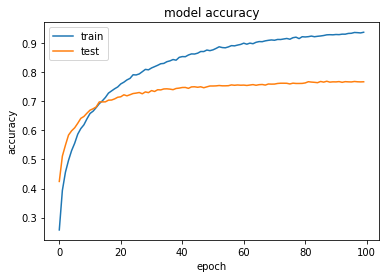

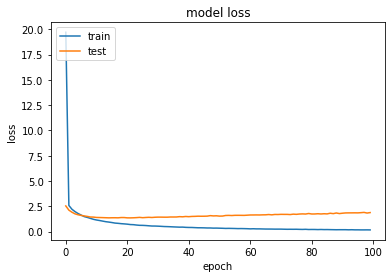

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

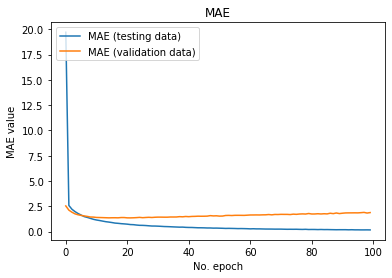

In [23]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

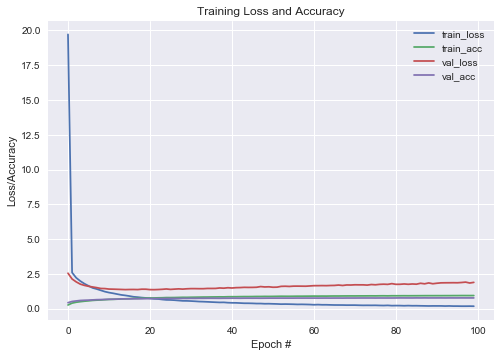

In [24]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()